In [ ]:
import sys
from pathlib import Path

# Add repo root to sys.path
sys.path.append(str(Path(__file__).resolve().parent.parent.parent))
from src.utils.packages import *
from src.config.config import RAW_DATA_PATH, PROCESSED_DATA_PATH, MODEL_PATH, VAL_RESULTS_PATH, OUTPUT_PATH
from src.utils.utils import preprocess_data, train_and_validate_models, predict_test_data

In [ ]:
train_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "test.csv"))

In [10]:
data = pd.concat(
    [train_df.assign(source="train_data"), test_df.assign(source="test_data")],
    ignore_index=True,
    copy=False
)

In [11]:
data[:2]

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
0           FDA15         9.30          Low Fat         0.016047        Dairy   
1           DRC01         5.92          Regular         0.019278  Soft Drinks   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  249.8092            OUT049                       1999      Medium   
1   48.2692            OUT018                       2009      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales      source  
0               Tier 1  Supermarket Type1          3735.1380  train_data  
1               Tier 3  Supermarket Type2           443.4228  train_data

In [150]:
exclude_cols = {'Item_Identifier', 'Outlet_Identifier', 'source'}
categorical_columns = [col for col in data.select_dtypes(include='object').columns if col not in exclude_cols]

In [151]:
for col in categorical_columns:
    unique_vals = data[col].dropna().unique().tolist()
    print(f"Unique values in '{col}':")
    print(unique_vals)
    print("-" * 40)

Unique values in 'Item_Fat_Content':
['Low Fat', 'Regular', 'low fat', 'LF', 'reg']
----------------------------------------
Unique values in 'Item_Type':
['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables', 'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods', 'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned', 'Breads', 'Starchy Foods', 'Others', 'Seafood']
----------------------------------------
Unique values in 'Outlet_Size':
['Medium', 'High', 'Small']
----------------------------------------
Unique values in 'Outlet_Location_Type':
['Tier 1', 'Tier 3', 'Tier 2']
----------------------------------------
Unique values in 'Outlet_Type':
['Supermarket Type1', 'Supermarket Type2', 'Grocery Store', 'Supermarket Type3']
----------------------------------------


In [152]:

data['Item_Fat_Content'] = data['Item_Fat_Content'].str.strip().str.lower()

# Map normalized values back to standard names
mapping = {
    'lf': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular',
    'regular': 'Regular'
}

data['Item_Fat_Content'] = data['Item_Fat_Content'].map(mapping).fillna(data['Item_Fat_Content'])

In [153]:
for col in categorical_columns:
    unique_vals = data[col].dropna().unique().tolist()
    print(f"Unique values in '{col}':")
    print(unique_vals)
    print("-" * 40)

Unique values in 'Item_Fat_Content':
['Low Fat', 'Regular']
----------------------------------------
Unique values in 'Item_Type':
['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables', 'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods', 'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned', 'Breads', 'Starchy Foods', 'Others', 'Seafood']
----------------------------------------
Unique values in 'Outlet_Size':
['Medium', 'High', 'Small']
----------------------------------------
Unique values in 'Outlet_Location_Type':
['Tier 1', 'Tier 3', 'Tier 2']
----------------------------------------
Unique values in 'Outlet_Type':
['Supermarket Type1', 'Supermarket Type2', 'Grocery Store', 'Supermarket Type3']
----------------------------------------


In [9]:
data.nunique(dropna=True).sort_values(ascending=False)

Item_Visibility              13006
Item_MRP                      8052
Item_Outlet_Sales             3493
Item_Identifier               1559
Item_Weight                    415
Item_Type                       16
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Type                      4
Outlet_Location_Type             3
Outlet_Size                      3
Item_Fat_Content                 2
source                           2
dtype: int64

In [154]:
null_summary = data.isnull().agg(['sum', 'mean']).T
null_summary.columns = ['missing_count', 'missing_percentage']
null_summary['missing_percentage'] *= 100

In [155]:
null_summary

missing_count  missing_percentage
Item_Identifier                      0.0            0.000000
Item_Weight                       2439.0           17.171219
Item_Fat_Content                     0.0            0.000000
Item_Visibility                      0.0            0.000000
Item_Type                            0.0            0.000000
Item_MRP                             0.0            0.000000
Outlet_Identifier                    0.0            0.000000
Outlet_Establishment_Year            0.0            0.000000
Outlet_Size                       4016.0           28.273726
Outlet_Location_Type                 0.0            0.000000
Outlet_Type                          0.0            0.000000
Item_Outlet_Sales                 5681.0           39.995776
source                               0.0            0.000000

In [156]:
data.describe(percentiles=[0.01, 0.1, 0.75, 0.9, 0.99])

Item_Weight  ...  Item_Outlet_Sales
count  11765.000000  ...        8523.000000
mean      12.792854  ...        2181.288914
std        4.652502  ...        1706.499616
min        4.555000  ...          33.290000
1%         5.150000  ...          83.890800
10%        6.655000  ...         343.552800
50%       12.600000  ...        1794.331000
75%       16.750000  ...        3101.296400
90%       19.350000  ...        4570.051200
99%       20.850000  ...        7366.011720
max       21.350000  ...       13086.964800

[11 rows x 5 columns]

In [157]:
# Create a dictionary of value counts DataFrames for each categorical column
category_frequencies = {
    col: data[col].value_counts(dropna=True).rename_axis(col).reset_index(name='frequency')
    for col in categorical_columns
}

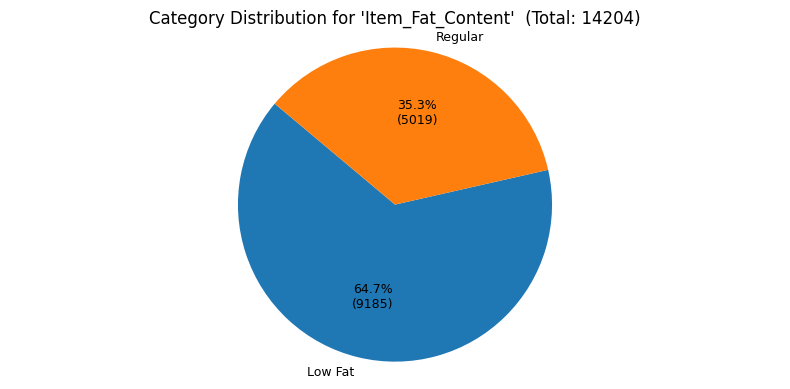

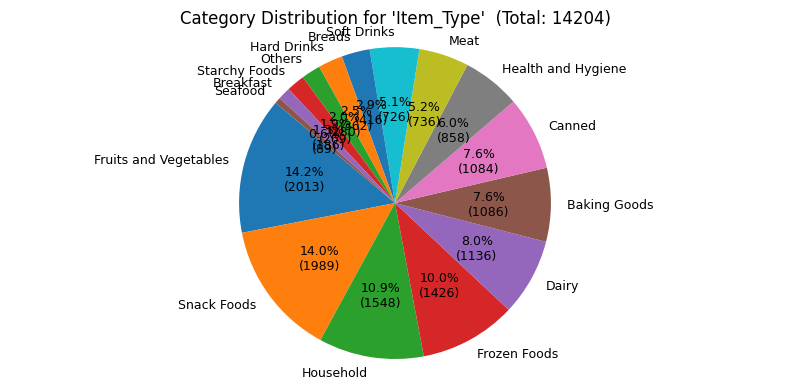

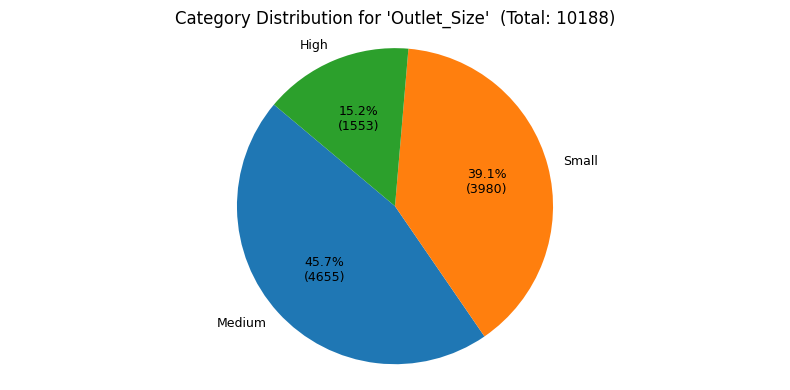

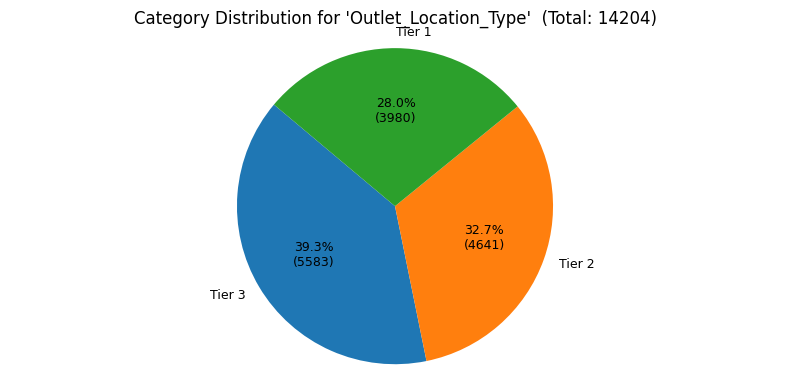

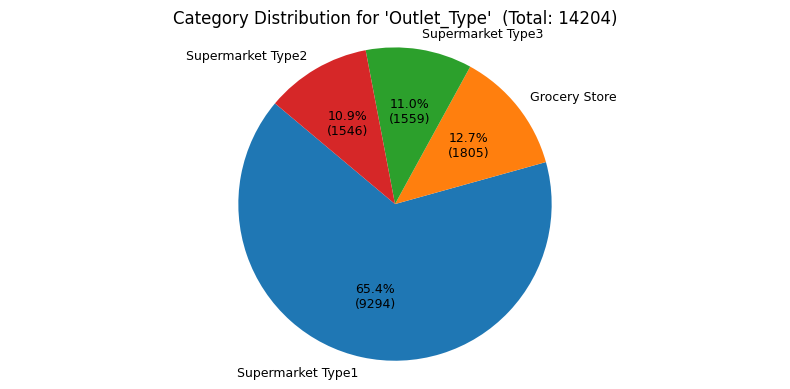

In [158]:
for col, freq_df in category_frequencies.items():
    total = freq_df['frequency'].sum()
    
    def make_autopct(values):
        def my_autopct(pct):
            absolute = int(round(pct * total / 100.0))
            return f"{pct:.1f}%\n({absolute})"
        return my_autopct

    plt.figure(figsize=(8, 4))
    plt.pie(
        freq_df['frequency'],
        labels=freq_df[col],
        autopct=make_autopct(freq_df['frequency']),
        startangle=140,
        textprops={'fontsize': 9}
    )
    plt.title(f"Category Distribution for '{col}'  (Total: {total})")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [159]:

def human_format(num):
    abs_num = abs(num)
    if abs_num >= 1_000_000_000:
        val = num / 1_000_000_000
        return f"{val:.2f}B"
    elif abs_num >= 1_000_000:
        val = num / 1_000_000
        return f"{val:.2f}M"
    elif abs_num >= 1_000:
        val = num / 1_000
        return f"{val:.2f}K"
    else:
        # For numbers < 1000, keep 2 decimals if fractional, else no decimals
        if isinstance(num, float) and not num.is_integer():
            return f"{num:.2f}"
        else:
            return f"{int(num)}"

def plot_sales_heatmaps(df, categorical_cols, target_col="Item_Outlet_Sales", agg_type="sum"):
    """
    Plot heatmaps of aggregated values of target_col grouped by pairs of categorical columns.
    
    Parameters:
    - df: pandas DataFrame
    - categorical_cols: list of categorical column names (at least 2)
    - target_col: column to aggregate on (ignored if agg_type=='count')
    - agg_type: aggregation type - 'sum', 'mean', or 'count'
    """
    
    # Validate agg_type
    agg_type = agg_type.lower()
    if agg_type not in ['sum', 'mean', 'count']:
        raise ValueError("agg_type must be one of ['sum', 'mean', 'count']")
    
    # If exactly two categorical columns, just plot one heatmap
    pairs = [categorical_cols] if len(categorical_cols) == 2 else list(combinations(categorical_cols, 2))
    
    for col1, col2 in pairs:
        if agg_type == "count":
            # Count how many rows per combination (ignore target_col)
            pivot = pd.crosstab(df[col1], df[col2])
            annot_data = pivot  # counts are usually manageable as is
        else:
            # Aggregate sum or mean of target_col
            pivot = pd.pivot_table(
                df,
                values=target_col,
                index=col1,
                columns=col2,
                aggfunc=agg_type,
                fill_value=0
            )
            annot_data = pivot.stack().map(human_format).unstack()
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot, annot=annot_data, fmt="", cmap="YlGnBu")
        plt.title(f"{agg_type.capitalize()} of {target_col} by {col1} and {col2}\n(Total records: {len(df)})")
        plt.xlabel(col2)
        plt.ylabel(col1)
        plt.tight_layout()
        plt.show()

In [161]:
data[:2]

Item_Identifier  Item_Weight  ... Item_Outlet_Sales      source
0           FDA15         9.30  ...         3735.1380  train_data
1           DRC01         5.92  ...          443.4228  train_data

[2 rows x 13 columns]

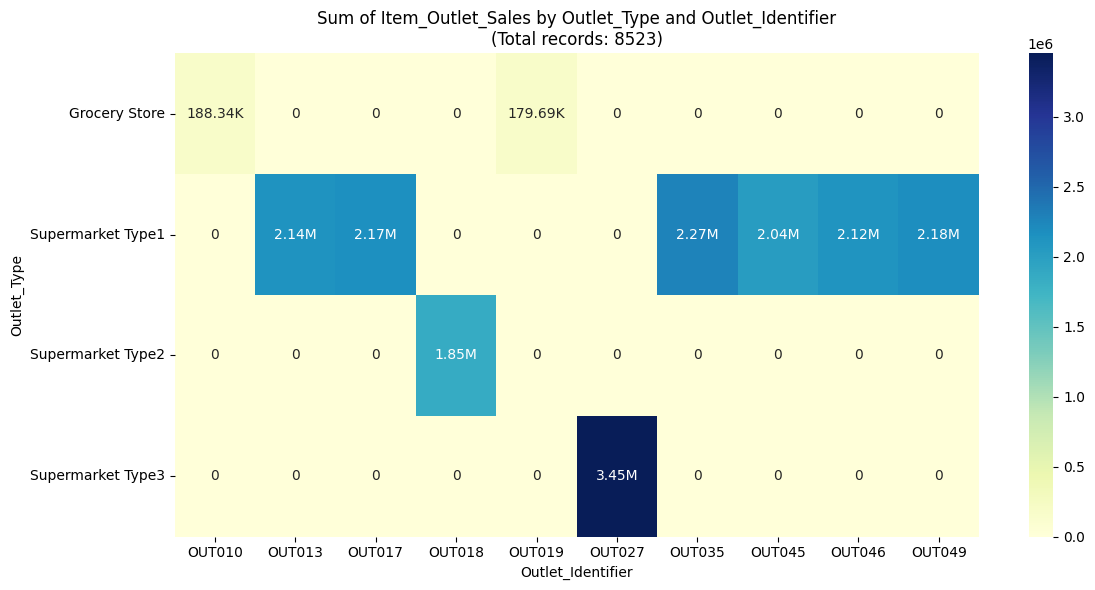

In [170]:
plot_sales_heatmaps(data[data['source'] == "train_data"], ['Outlet_Type', 'Outlet_Identifier'], target_col="Item_Outlet_Sales", agg_type="sum")

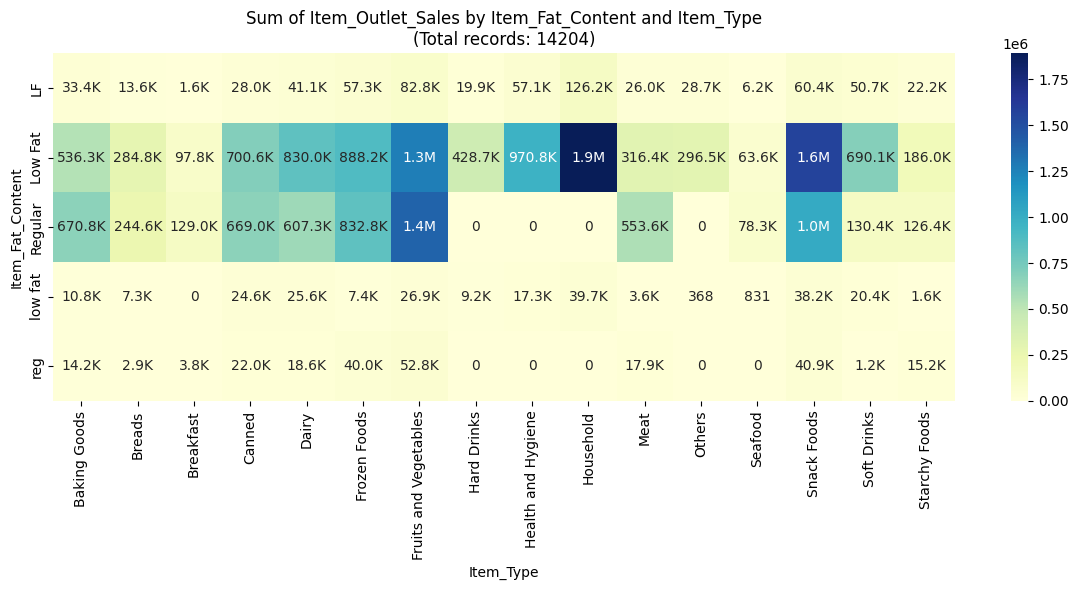

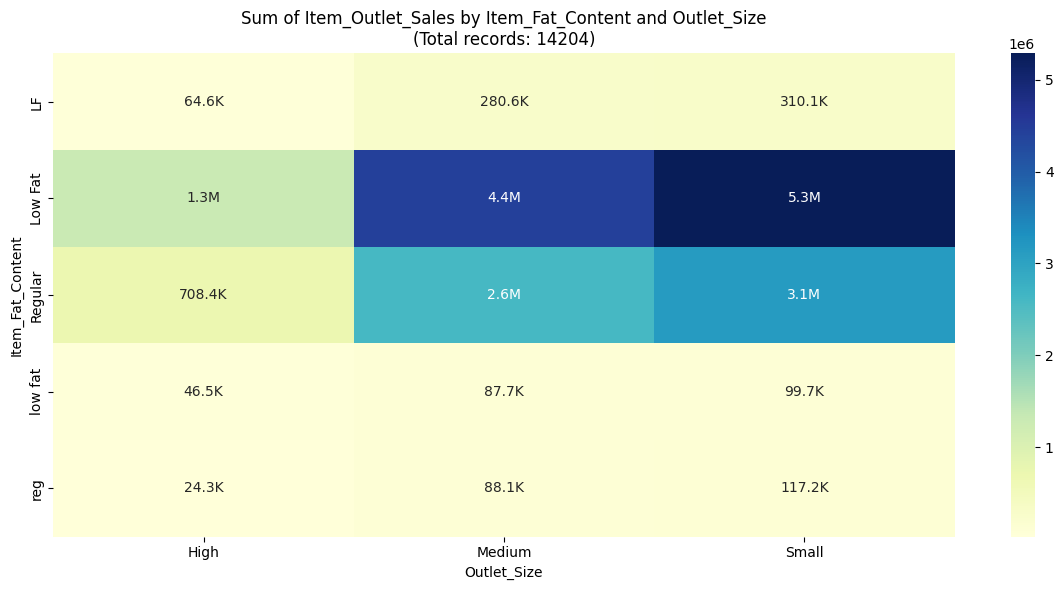

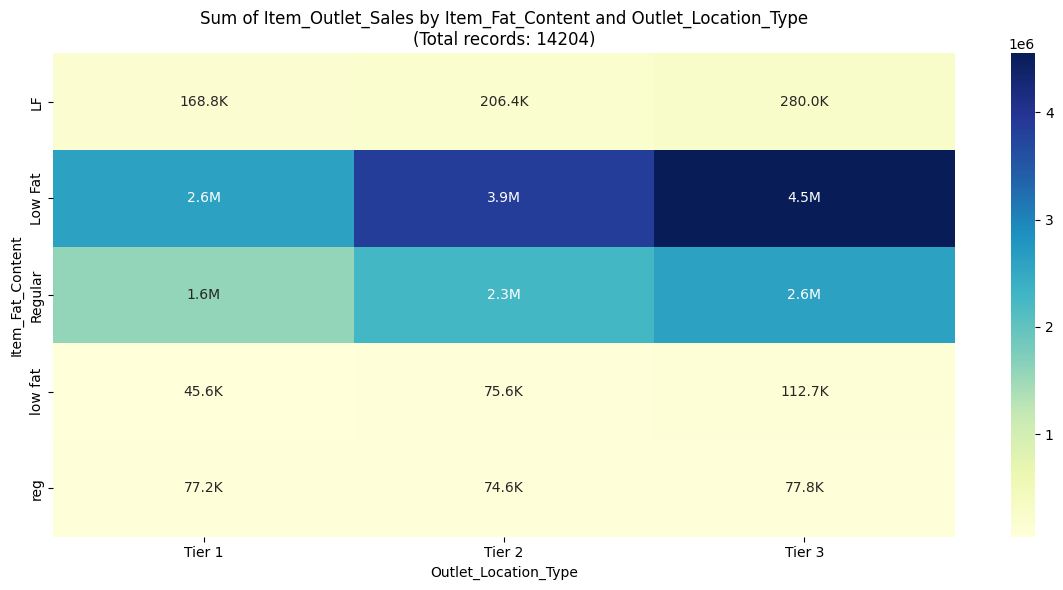

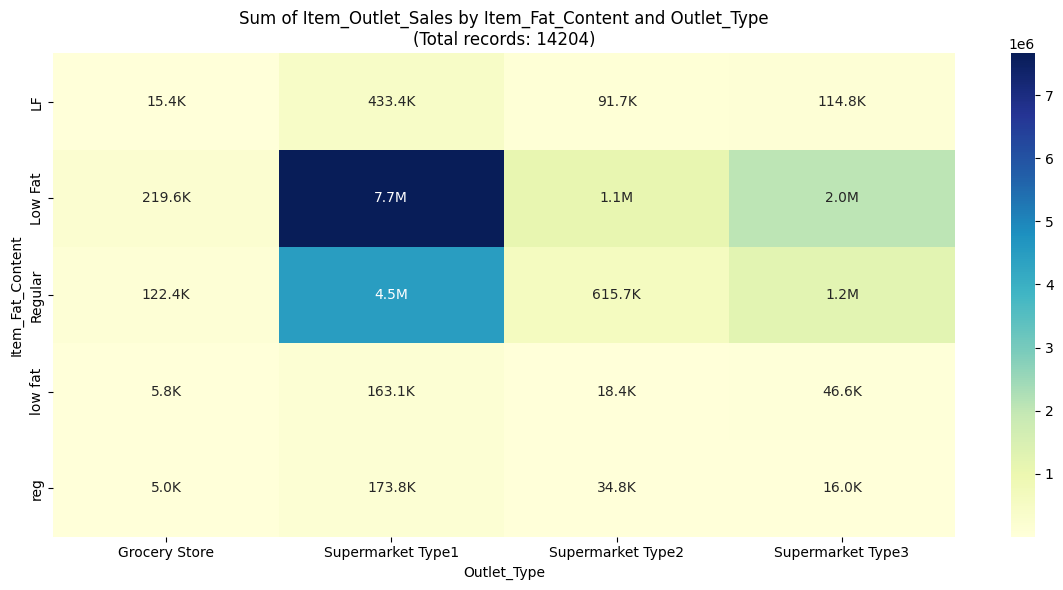

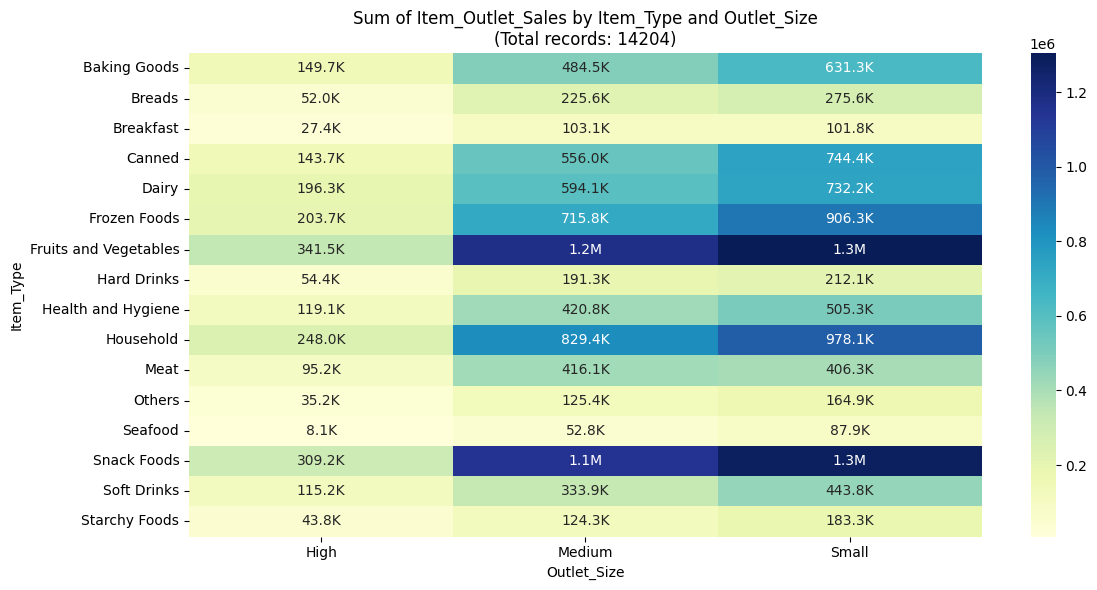

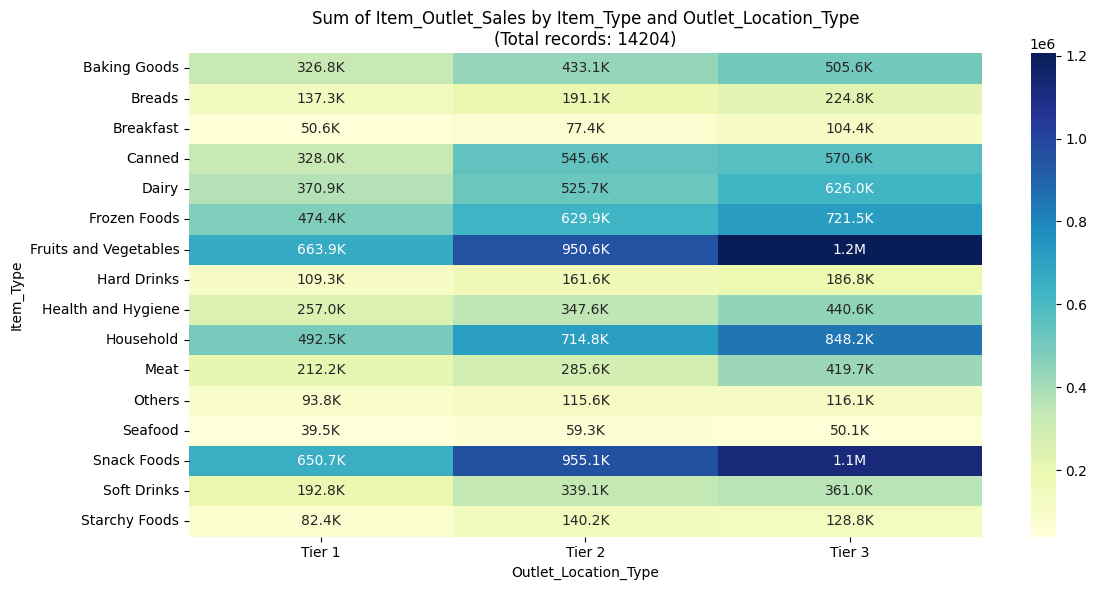

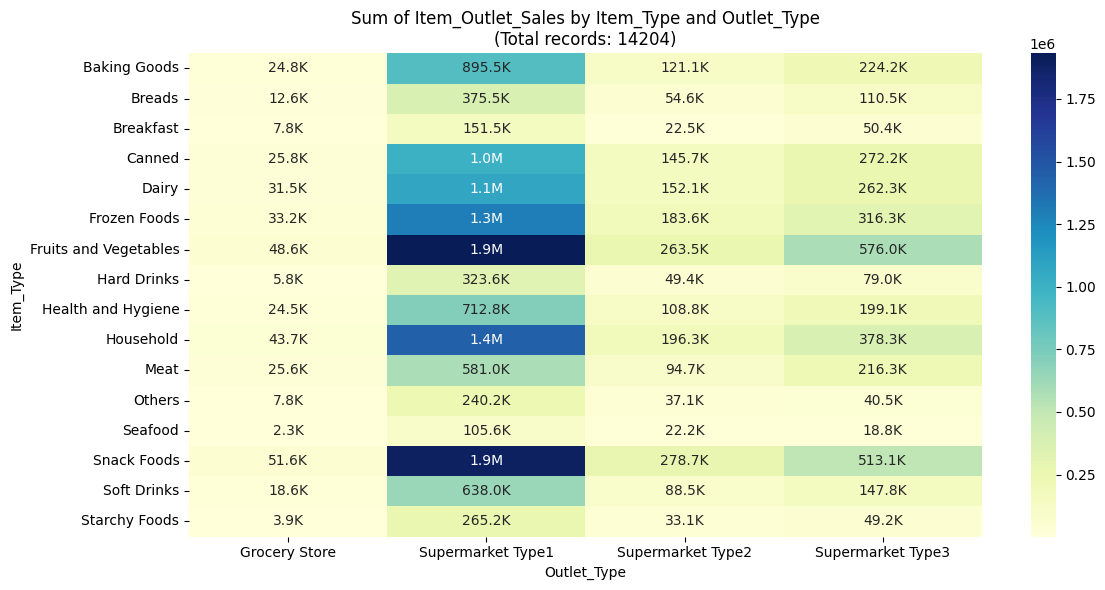

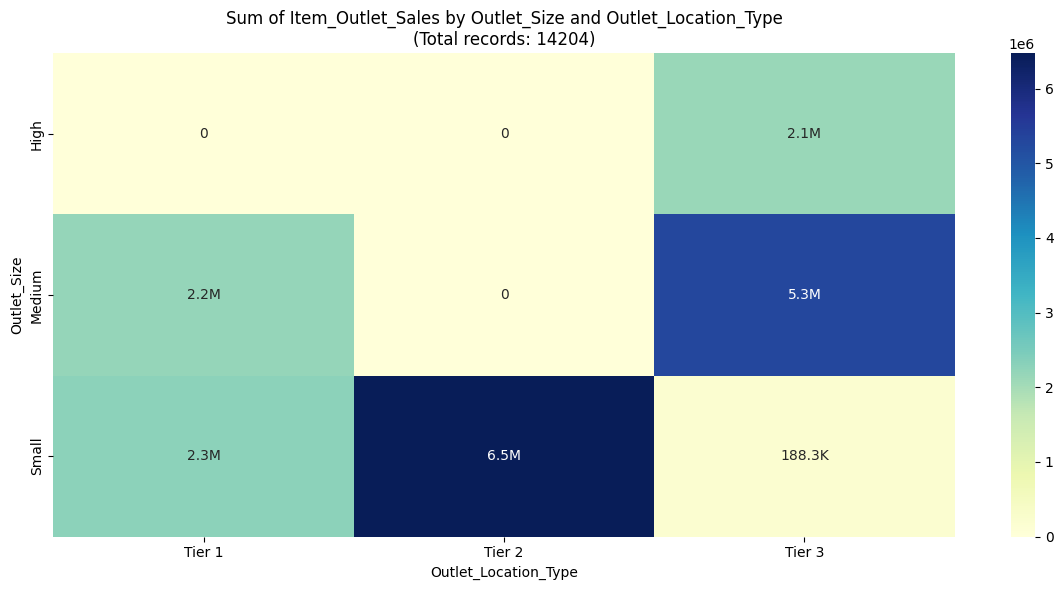

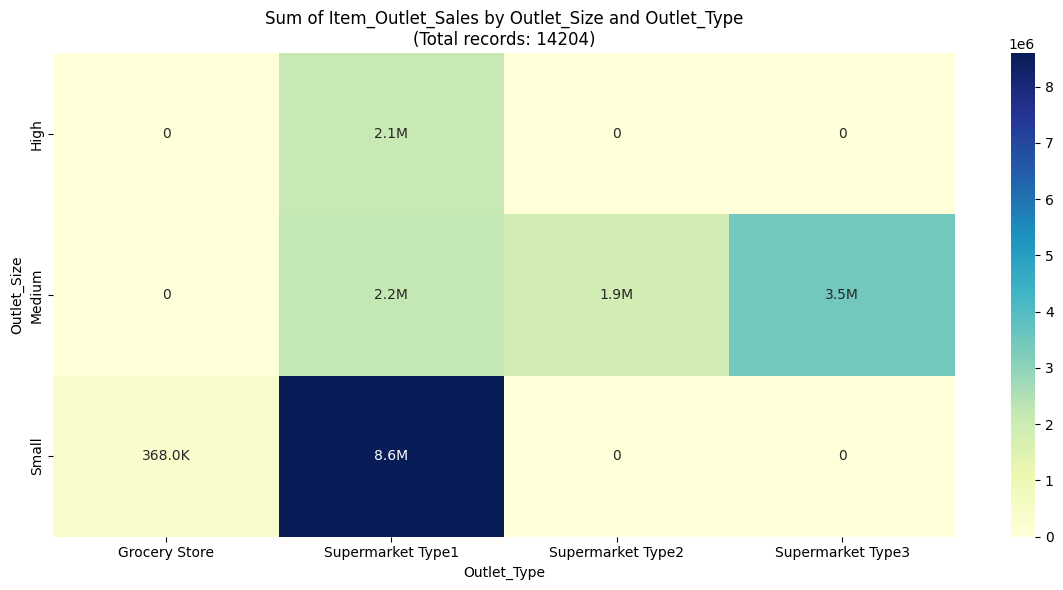

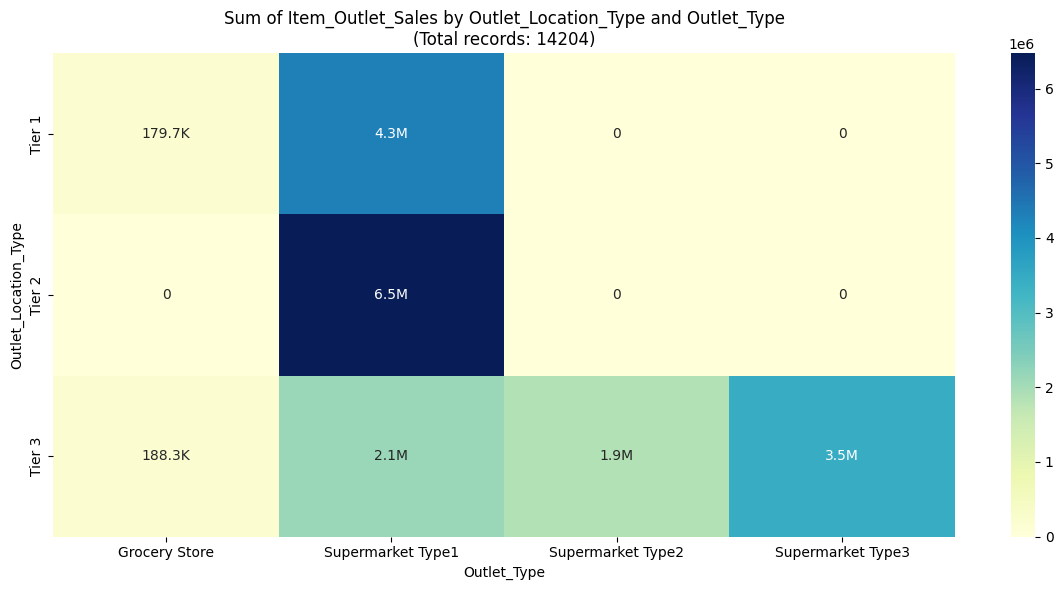

In [133]:
plot_sales_heatmaps(data, categorical_columns, target_col="Item_Outlet_Sales", agg_type="sum")

In [215]:
data[['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size']].drop_duplicates()

Outlet_Type Outlet_Location_Type Outlet_Size
0   Supermarket Type1               Tier 1      Medium
1   Supermarket Type2               Tier 3      Medium
3       Grocery Store               Tier 3         NaN
4   Supermarket Type1               Tier 3        High
7   Supermarket Type3               Tier 3      Medium
8   Supermarket Type1               Tier 2         NaN
11  Supermarket Type1               Tier 1       Small
19  Supermarket Type1               Tier 2       Small
23      Grocery Store               Tier 1       Small

In [15]:
# Average weight per item
avg_weight = data.groupby('Item_Identifier')['Item_Weight'].mean()

# Fill missing weights
data['Item_Weight'] = data.apply(
    lambda row: avg_weight[row['Item_Identifier']] if pd.isnull(row['Item_Weight']) else row['Item_Weight'],
    axis=1
)

# Calculate mode per Outlet_Type using pandas mode()
outlet_size_mode = data.groupby('Outlet_Type')['Outlet_Size'] \
                       .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing Outlet_Size
data['Outlet_Size'] = data['Outlet_Size'].fillna(data['Outlet_Type'].map(outlet_size_mode))

In [199]:
data[['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size']].drop_duplicates()

Outlet_Type Outlet_Location_Type Outlet_Size
0   Supermarket Type1               Tier 1      Medium
1   Supermarket Type2               Tier 3      Medium
3       Grocery Store               Tier 3       Small
4   Supermarket Type1               Tier 3        High
7   Supermarket Type3               Tier 3      Medium
8   Supermarket Type1               Tier 2       Small
11  Supermarket Type1               Tier 1       Small
23      Grocery Store               Tier 1       Small

In [200]:
data[:2]

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
0           FDA15         9.30          Low Fat         0.016047        Dairy   
1           DRC01         5.92          Regular         0.019278  Soft Drinks   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  249.8092            OUT049                       1999      Medium   
1   48.2692            OUT018                       2009      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales      source  
0               Tier 1  Supermarket Type1          3735.1380  train_data  
1               Tier 3  Supermarket Type2           443.4228  train_data

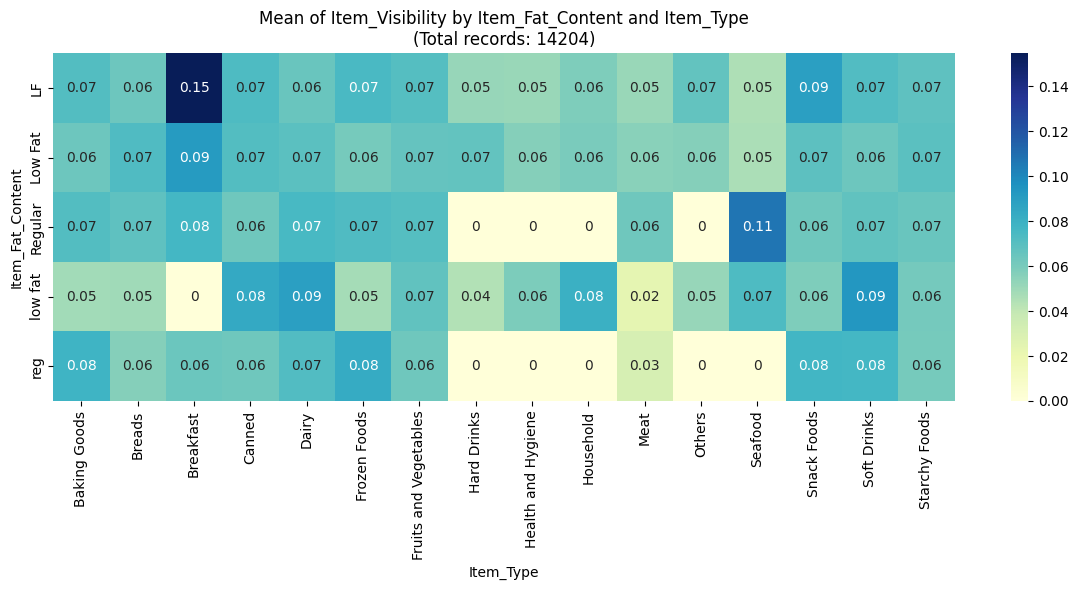

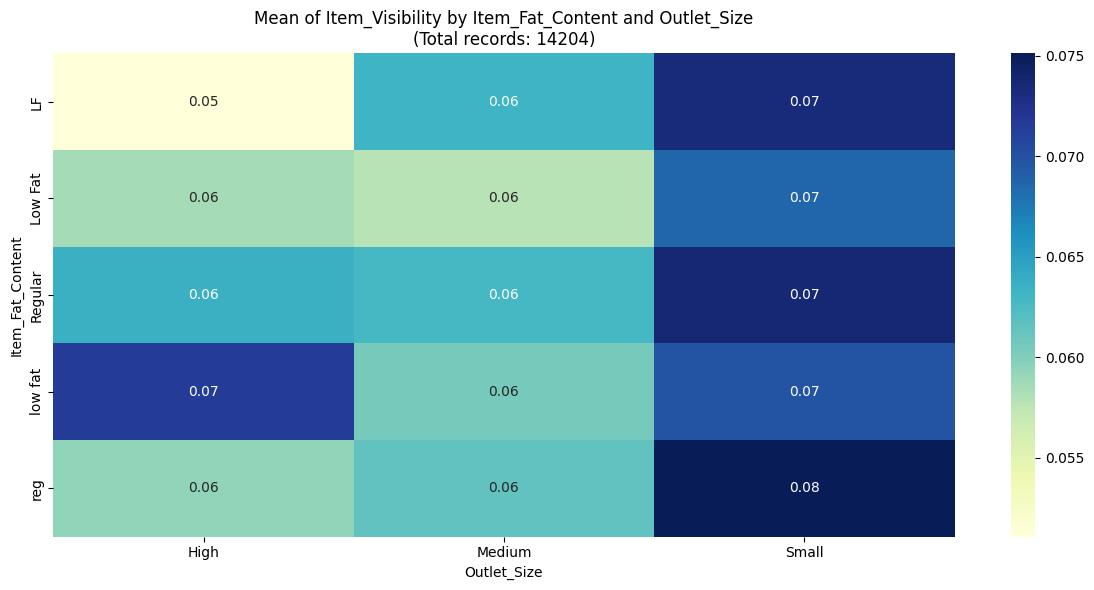

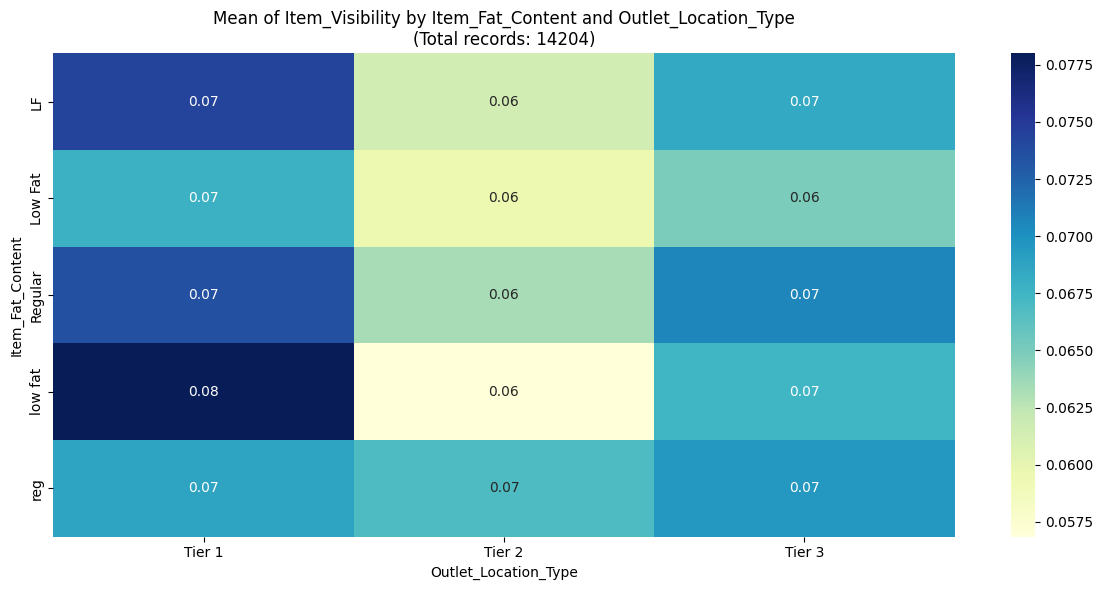

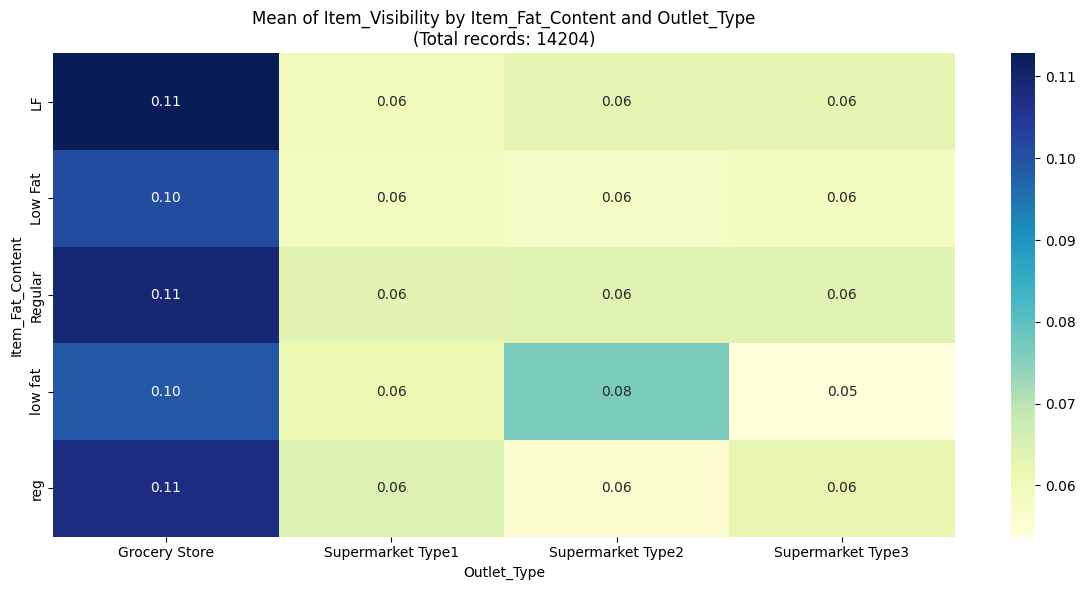

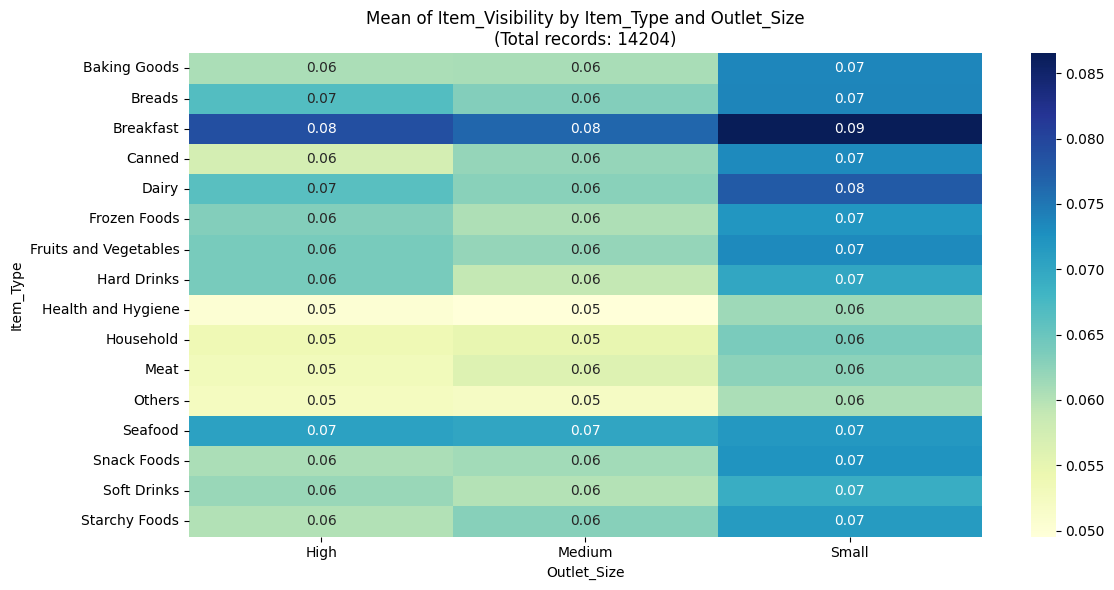

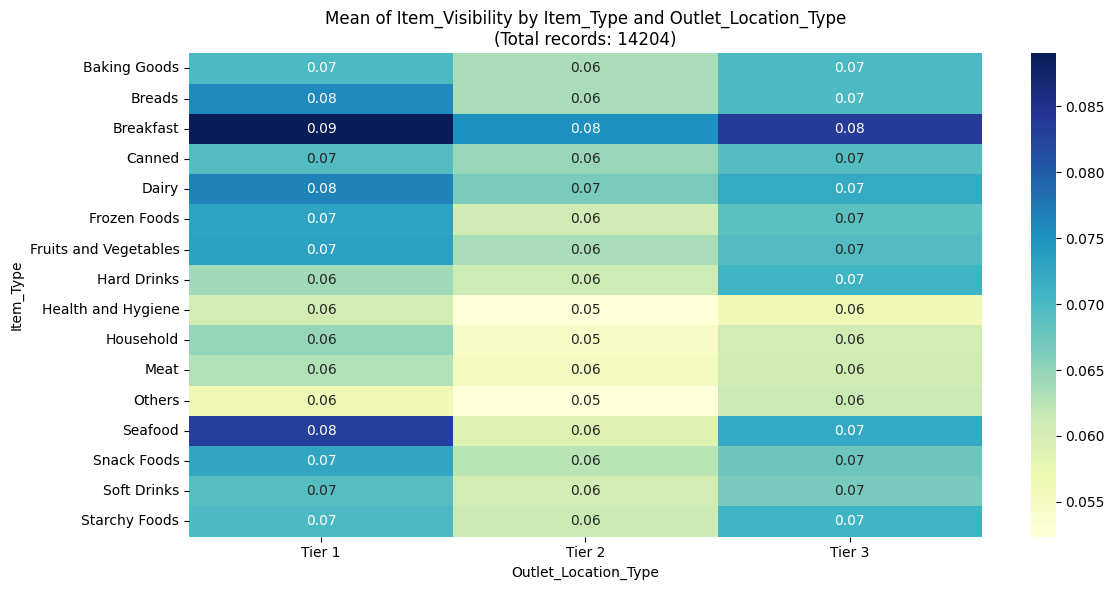

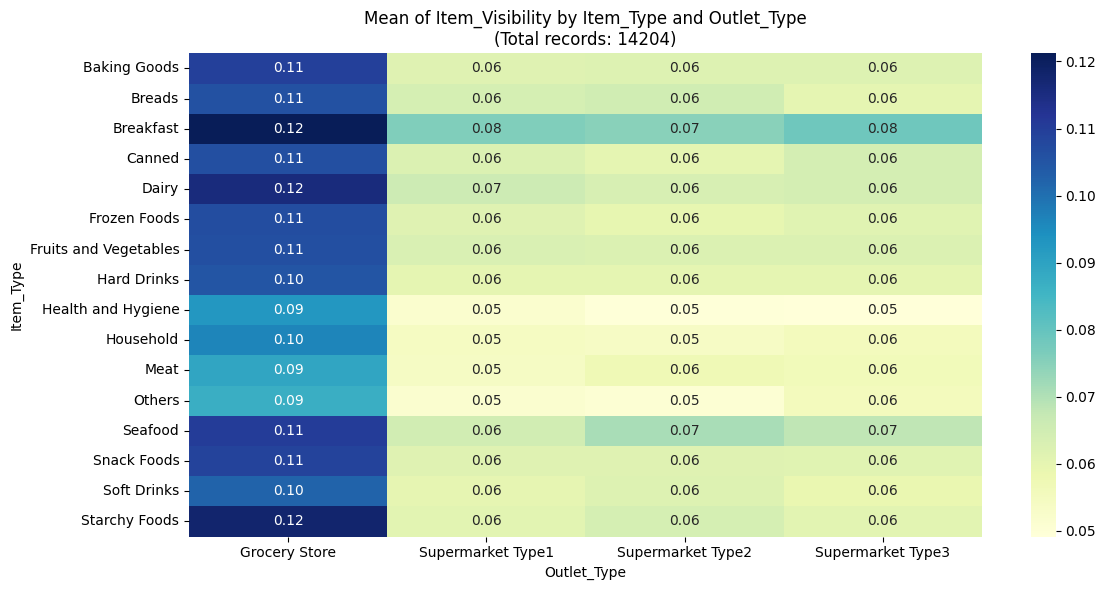

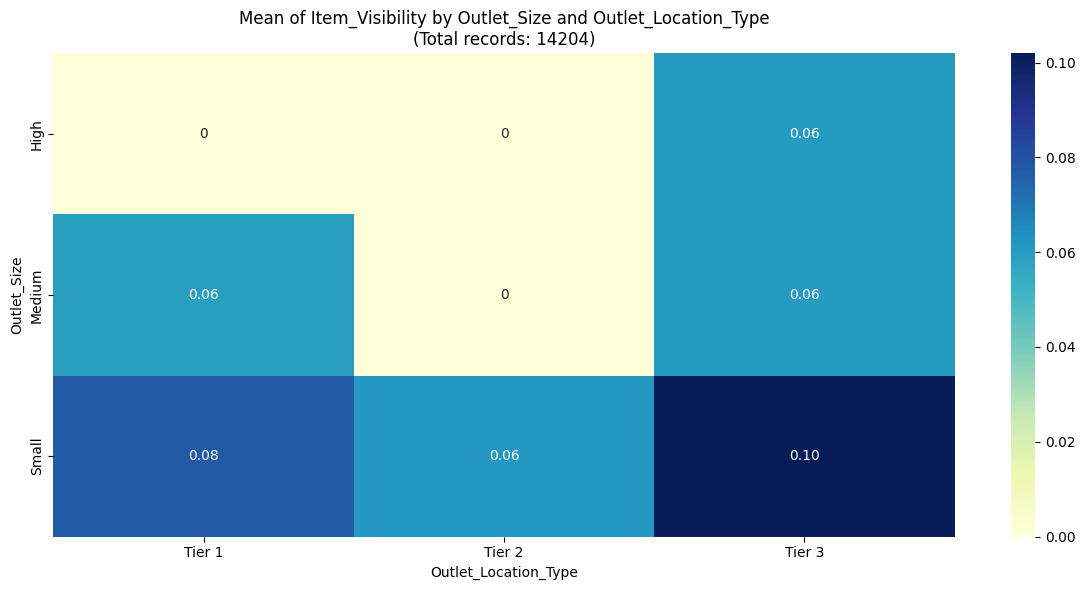

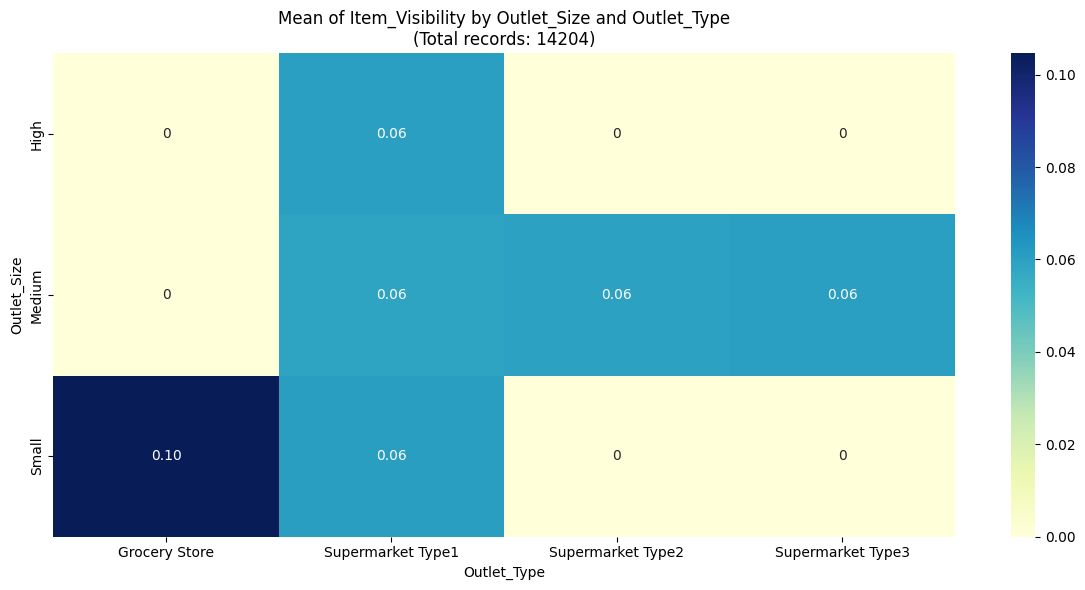

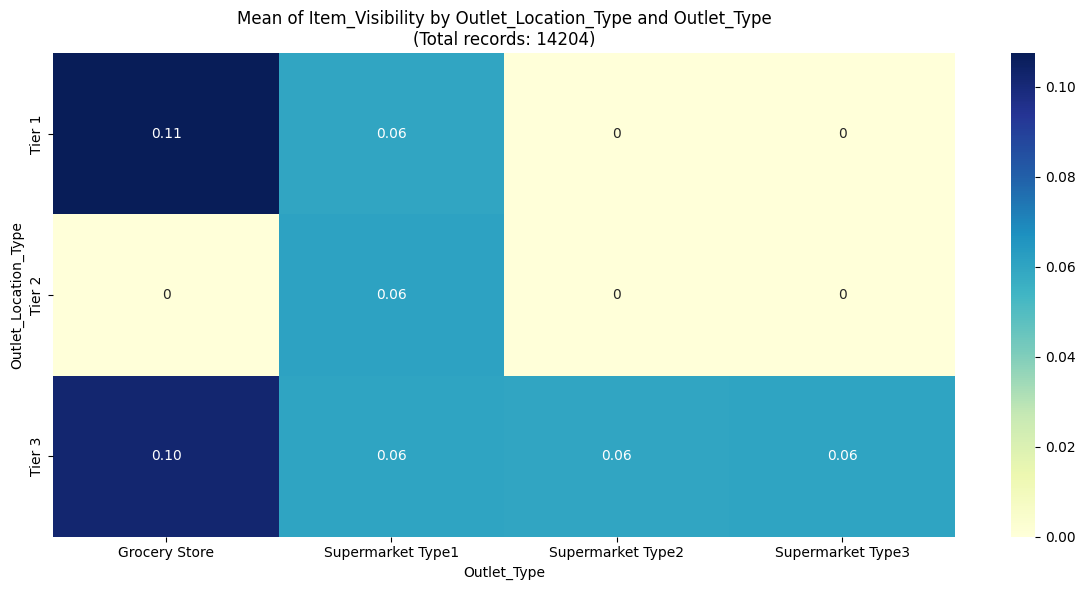

In [138]:
plot_sales_heatmaps(data, categorical_columns, target_col="Item_Visibility", agg_type="mean")

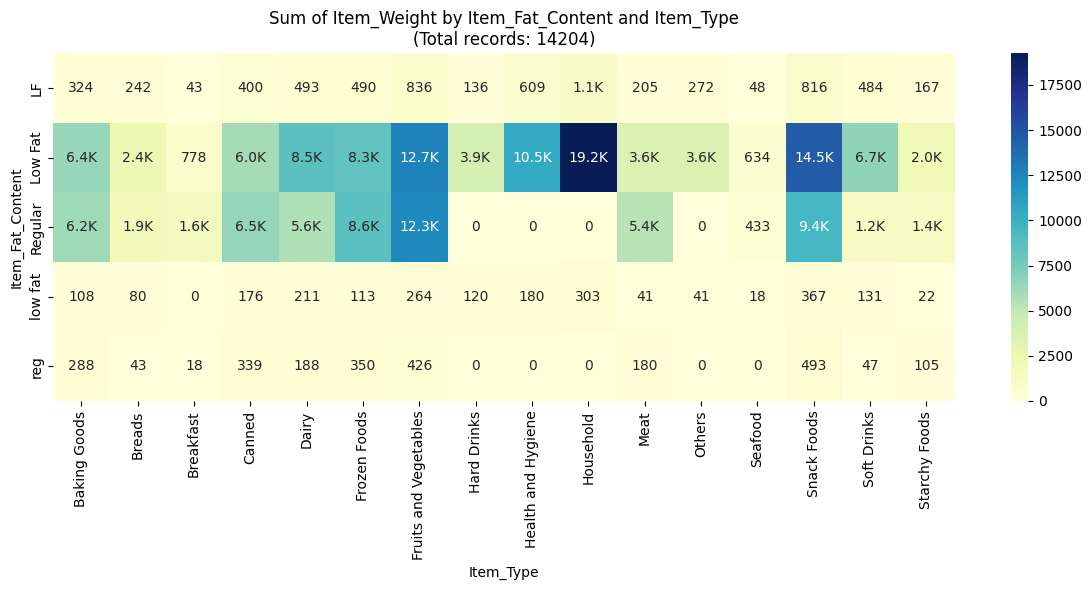

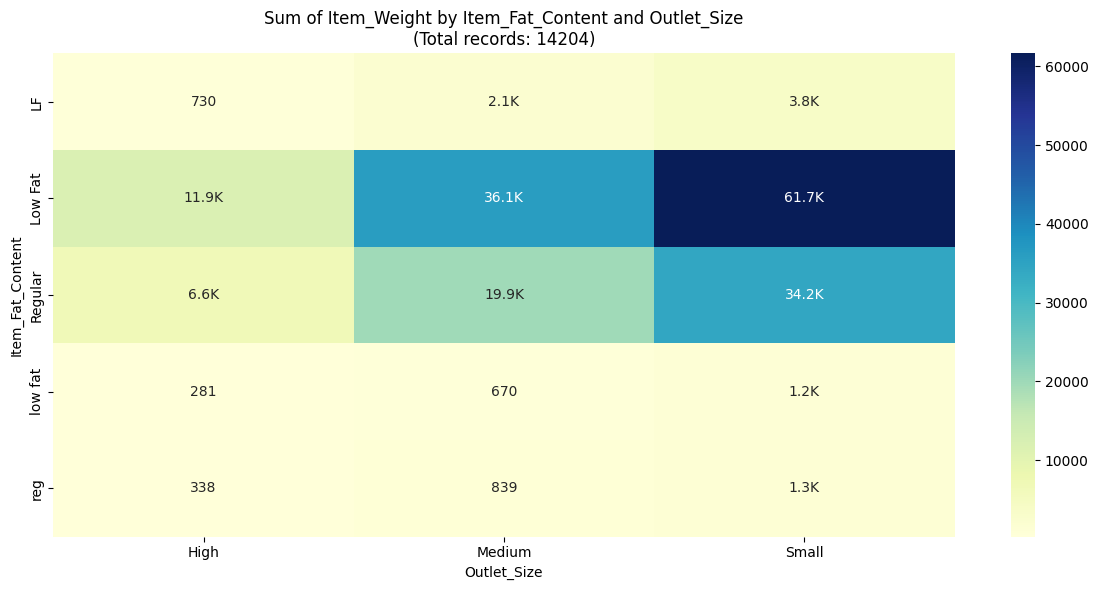

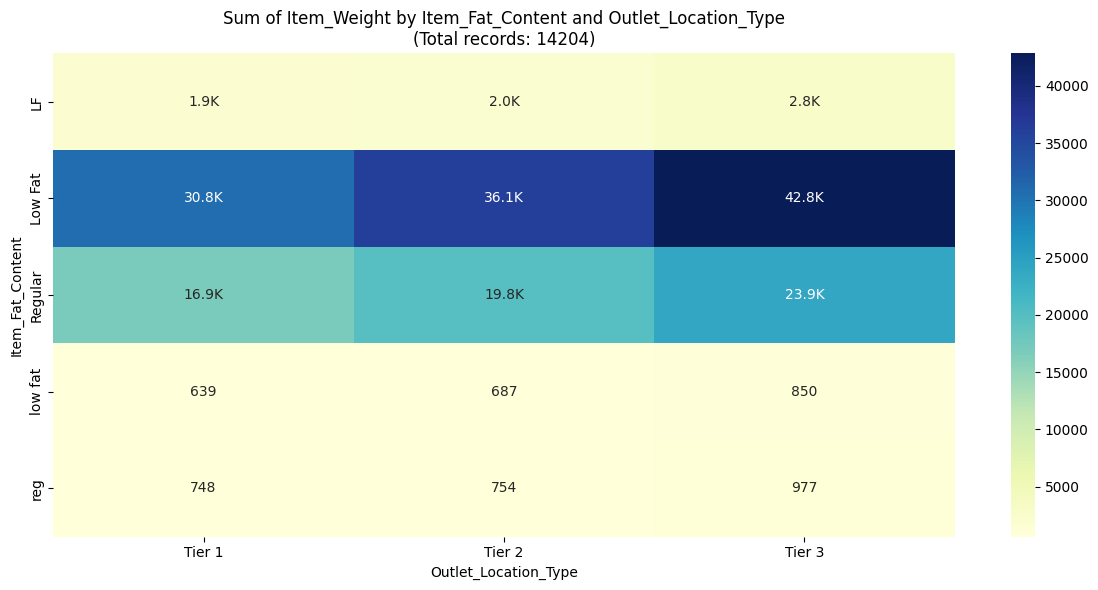

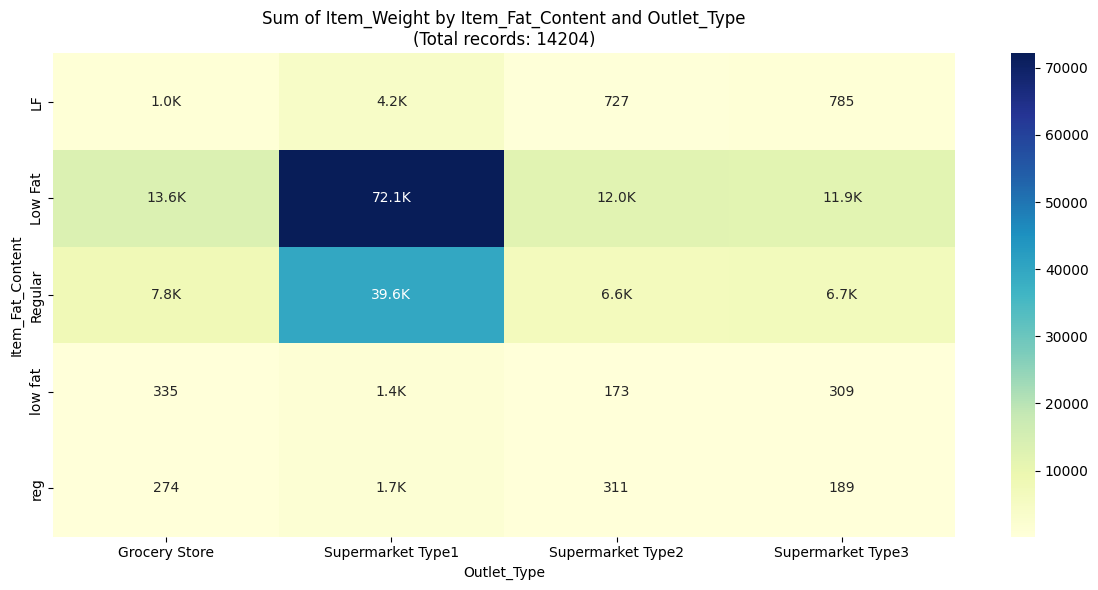

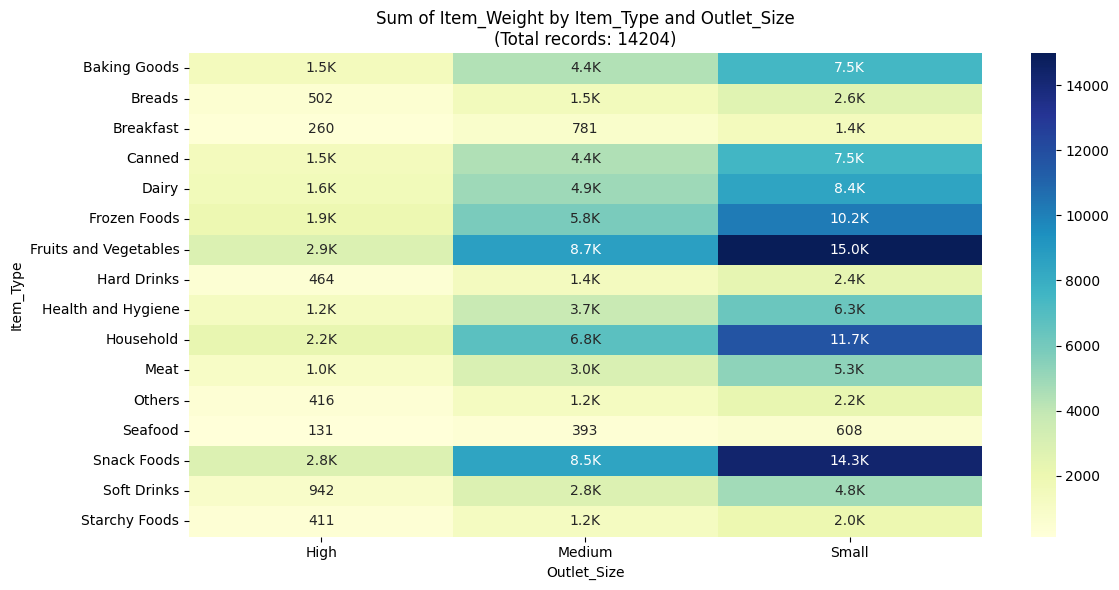

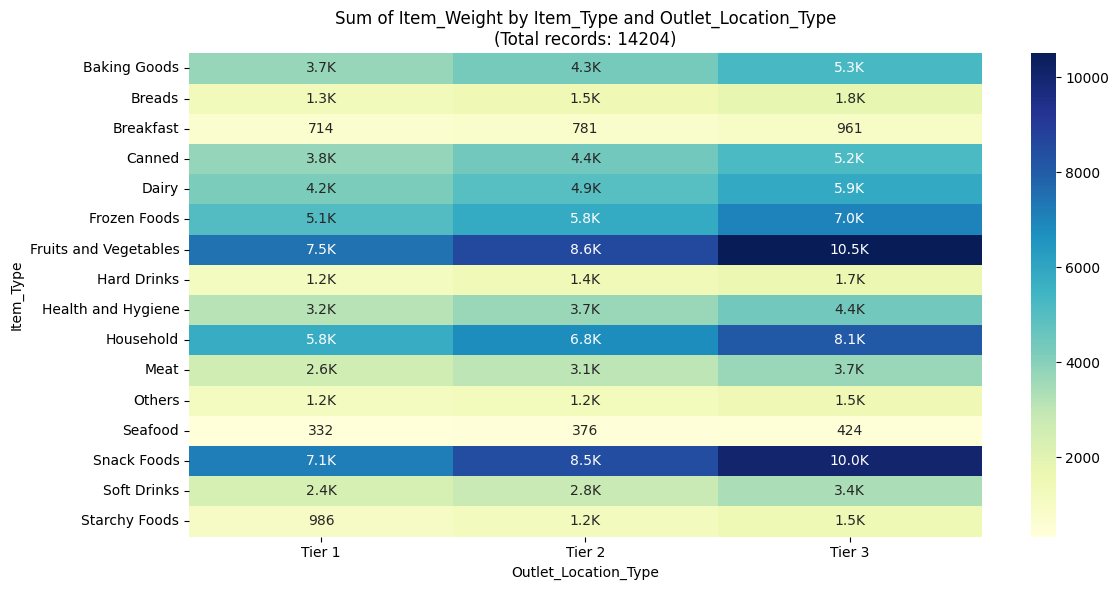

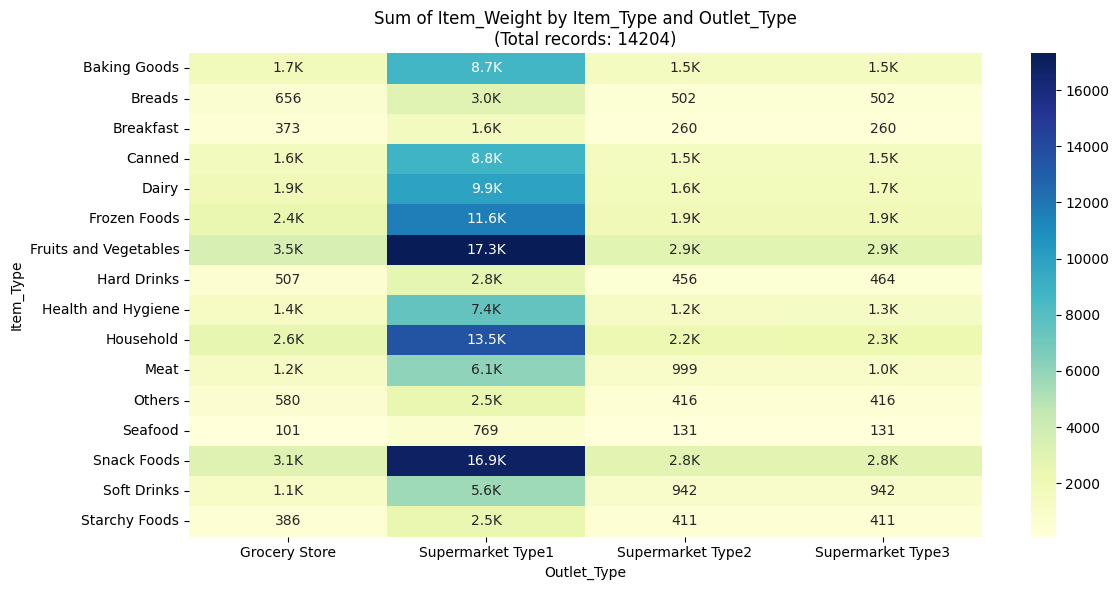

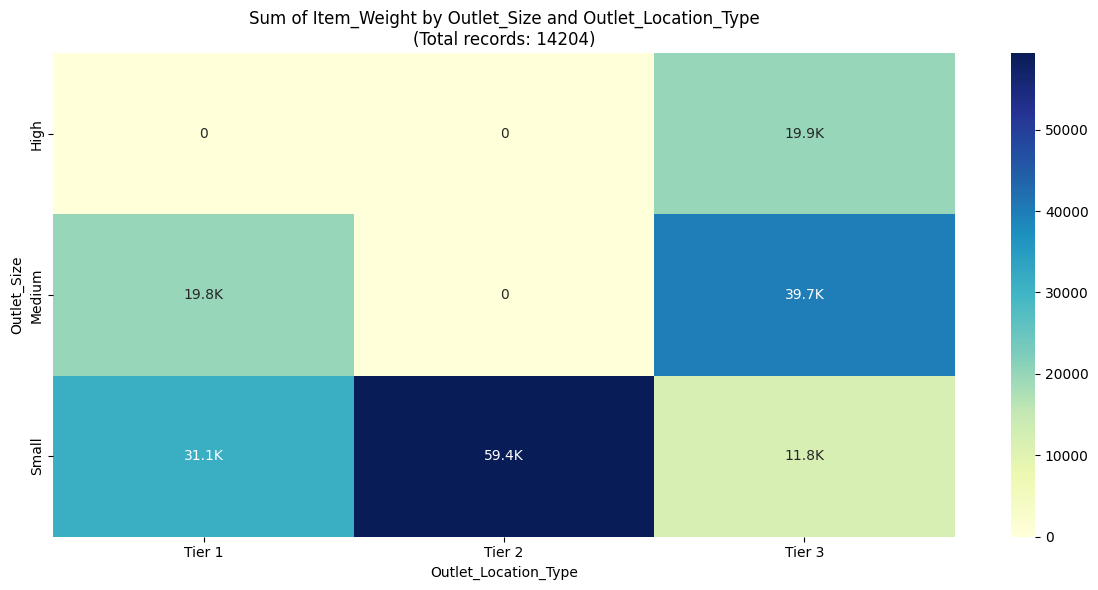

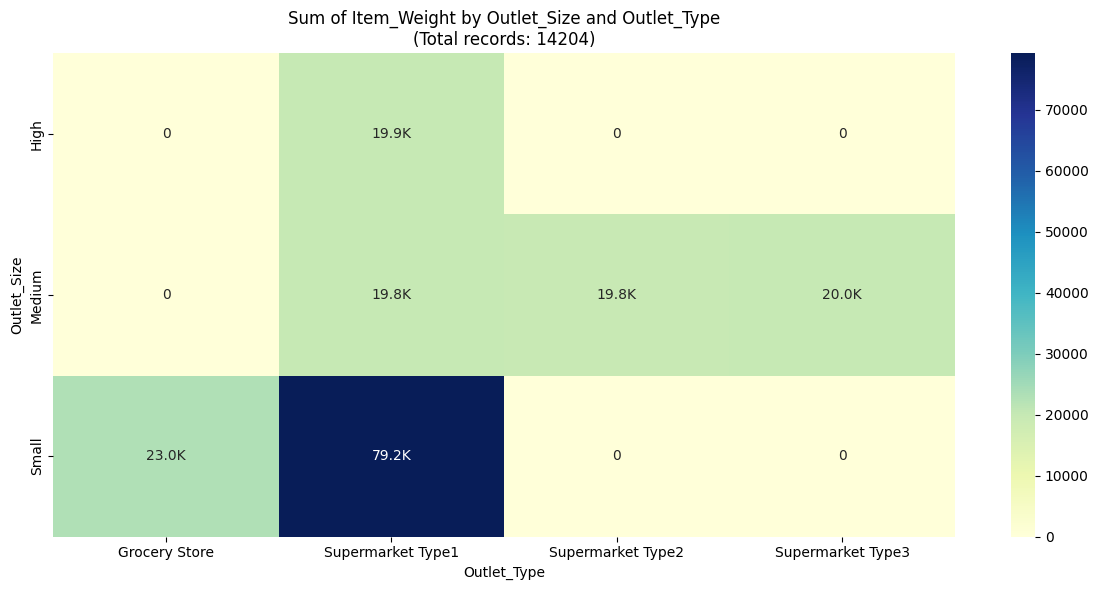

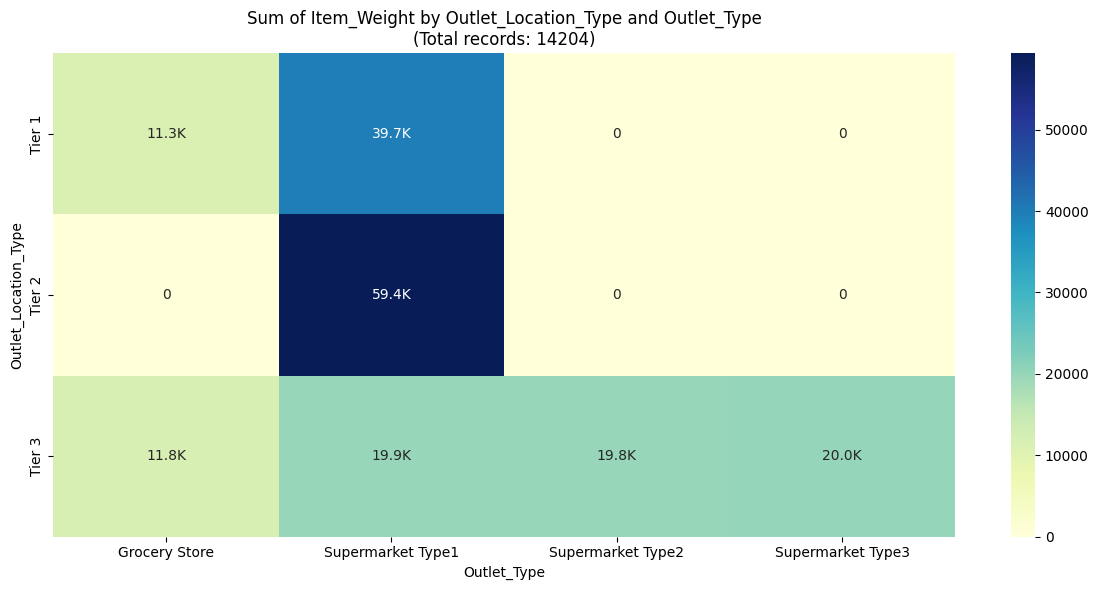

In [134]:
plot_sales_heatmaps(data, categorical_columns, target_col="Item_Weight", agg_type="sum")

In [ ]:
category_map = {
    'Dairy': 'Food',
    'Soft Drinks': 'Drinks',
    'Hard Drinks': 'Drinks',
    'Meat': 'Food',
    'Fruits and Vegetables': 'Food',
    'Household': 'Non-Consumable',
    'Baking Goods': 'Food',
    'Snack Foods': 'Food',
    'Frozen Foods': 'Food',
    'Breakfast': 'Food',
    'Health and Hygiene': 'Non-Consumable',
    'Canned': 'Food',
    'Breads': 'Food',
    'Starchy Foods': 'Food',
    'Others': 'Miscellaneous',
    'Seafood': 'Food'
}

data['Item_Category'] = data['Item_Type'].map(category_map).fillna('Miscellaneous')

In [219]:
data[:2]

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
0           FDA15         9.30          Low Fat         0.016047        Dairy   
1           DRC01         5.92          Regular         0.019278  Soft Drinks   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  249.8092            OUT049                       1999      Medium   
1   48.2692            OUT018                       2009      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales      source  \
0               Tier 1  Supermarket Type1          3735.1380  train_data   
1               Tier 3  Supermarket Type2           443.4228  train_data   

  Item_Category  
0          Food  
1        Drinks

In [17]:

data[['Item_Category', 'Item_Type']].drop_duplicates()

Item_Category              Item_Type
0              Food                  Dairy
1            Drinks            Soft Drinks
2              Food                   Meat
3              Food  Fruits and Vegetables
4    Non-Consumable              Household
5              Food           Baking Goods
6              Food            Snack Foods
8              Food           Frozen Foods
15             Food              Breakfast
16   Non-Consumable     Health and Hygiene
18           Drinks            Hard Drinks
29             Food                 Canned
33             Food                 Breads
72             Food          Starchy Foods
139   Miscellaneous                 Others
231            Food                Seafood

The data scientists at BigMart have collected 2013 sales data

In [18]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']

In [19]:
data[:2]

Item_Identifier  Item_Weight  ... Item_Category  Outlet_Years
0           FDA15         9.30  ...          Food            14
1           DRC01         5.92  ...        Drinks             4

[2 rows x 15 columns]

In [20]:
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Category','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [21]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Category','Outlet'])

In [180]:
data[:2]

Item_Identifier  Item_Weight  Item_Visibility    Item_Type  Item_MRP  \
0           FDA15         9.30         0.016047        Dairy  249.8092   
1           DRC01         5.92         0.019278  Soft Drinks   48.2692   

  Outlet_Identifier  Outlet_Establishment_Year  Item_Outlet_Sales      source  \
0            OUT049                       1999          3735.1380  train_data   
1            OUT018                       2009           443.4228  train_data   

   Outlet_Years  ...  Outlet_0  Outlet_1  Outlet_2  Outlet_3  Outlet_4  \
0            14  ...     False     False     False     False     False   
1             4  ...     False     False     False      True     False   

   Outlet_5  Outlet_6  Outlet_7  Outlet_8  Outlet_9  
0     False     False     False     False      True  
1     False     False     False     False     False  

[2 rows x 36 columns]

In [ ]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train_data"]
test = data.loc[data['source']=="test_data"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_12248\3227102250.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_12248\3227102250.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['source'],axis=1,inplace=True)


In [226]:
test

Item_Identifier  Item_Weight  Item_Visibility  Item_MRP  \
8523            FDW58       20.750         0.007565  107.8622   
8524            FDW14        8.300         0.038428   87.3198   
8525            NCN55       14.600         0.099575  241.7538   
8526            FDQ58        7.315         0.015388  155.0340   
8527            FDY38       13.600         0.118599  234.2300   
...               ...          ...              ...       ...   
14199           FDB58       10.500         0.013496  141.3154   
14200           FDD47        7.600         0.142991  169.1448   
14201           NCO17       10.000         0.073529  118.7440   
14202           FDJ26       15.300         0.000000  214.6218   
14203           FDU37        9.500         0.104720   79.7960   

      Outlet_Identifier  Outlet_Years  Item_Fat_Content_0  Item_Fat_Content_1  \
8523             OUT049            14                True               False   
8524             OUT017             6               False                True   
8525             OUT010            15                True               False   
8526             OUT017             6                True               False   
8527             OUT027            28               False                True   
...                 ...           ...                 ...                 ...   
14199            OUT046            16               False                True   
14200            OUT018             4               False                True   
14201            OUT045            11                True               False   
14202            OUT017             6               False                True   
14203            OUT045            11               False                True   

       Outlet_Location_Type_0  Outlet_Location_Type_1  ...  Outlet_0  \
8523                     True                   False  ...     False   
8524                    False                    True  ...     False   
8525                    False                   False  ...      True   
8526                    False                    True  ...     False   
8527                    False                   False  ...     False   
...                       ...                     ...  ...       ...   
14199                    True                   False  ...     False   
14200                   False                   False  ...     False   
14201                   False                    True  ...     False   
14202                   False                    True  ...     False   
14203                   False                    True  ...     False   

       Outlet_1  Outlet_2  Outlet_3  Outlet_4  Outlet_5  Outlet_6  Outlet_7  \
8523      False     False     False     False     False     False     False   
8524      False      True     False     False     False     False     False   
8525      False     False     False     False     False     False     False   
8526      False      True     False     False     False     False     False   
8527      False     False     False     False      True     False     False   
...         ...       ...       ...       ...       ...       ...       ...   
14199     False     False     False     False     False     False     False   
14200     False     False      True     False     False     False     False   
14201     False     False     False     False     False     False      True   
14202     False      True     False     False     False     False     False   
14203     False     False     False     False     False     False      True   

       Outlet_8  Outlet_9  
8523      False      True  
8524      False     False  
8525      False     False  
8526      False     False  
8527      False     False  
...         ...       ...  
14199      True     False  
14200     False     False  
14201     False     False  
14202     False     False  
14203     False     False  

[5681 rows x 32 columns]

Training LinearRegression...


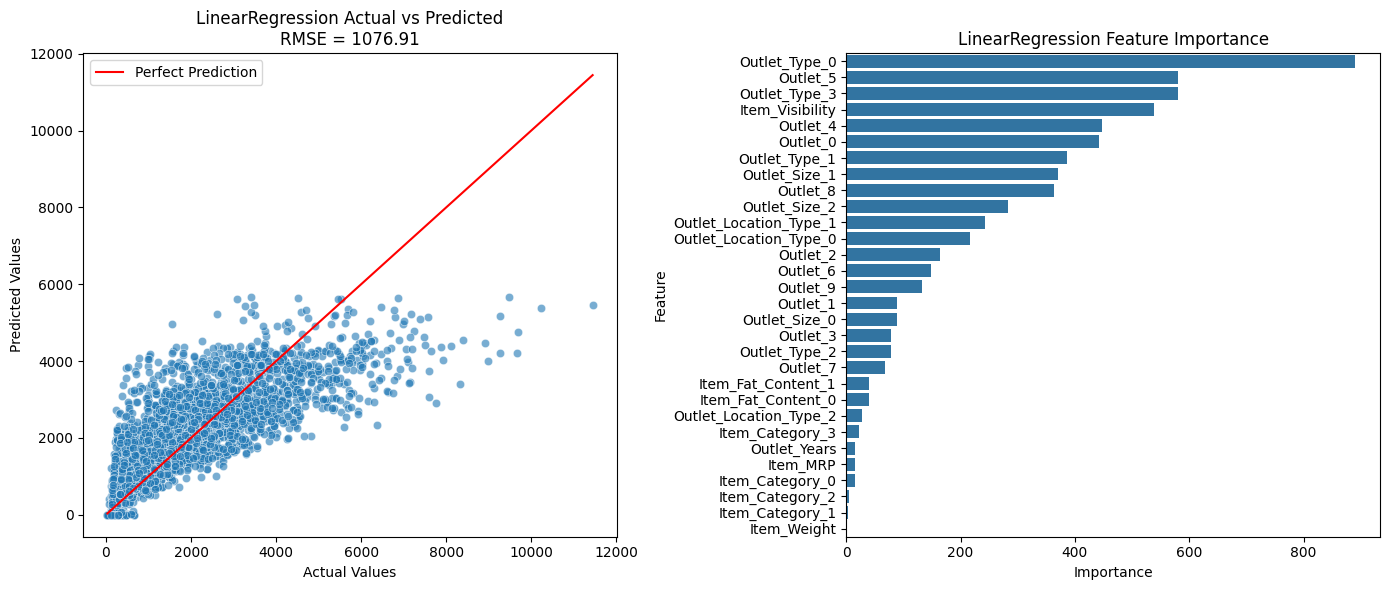

Training Ridge...


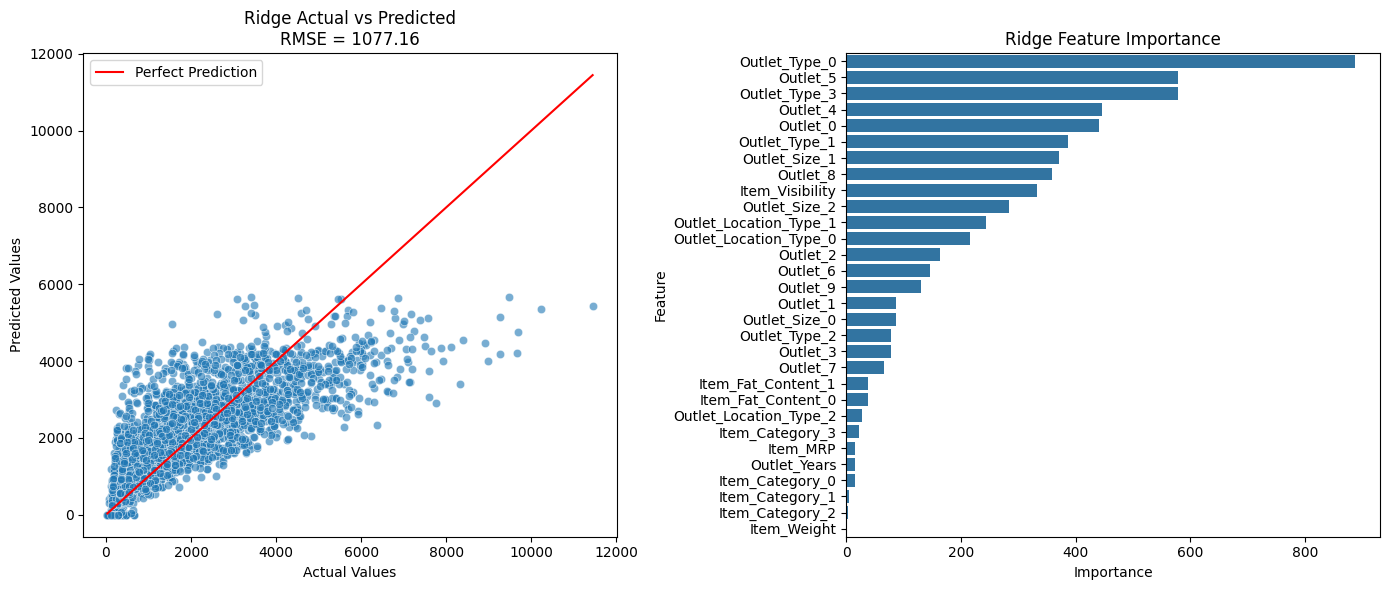

Training Lasso...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e+09, tolerance: 1.764e+06
  model = cd_fast.enet_coordinate_descent(


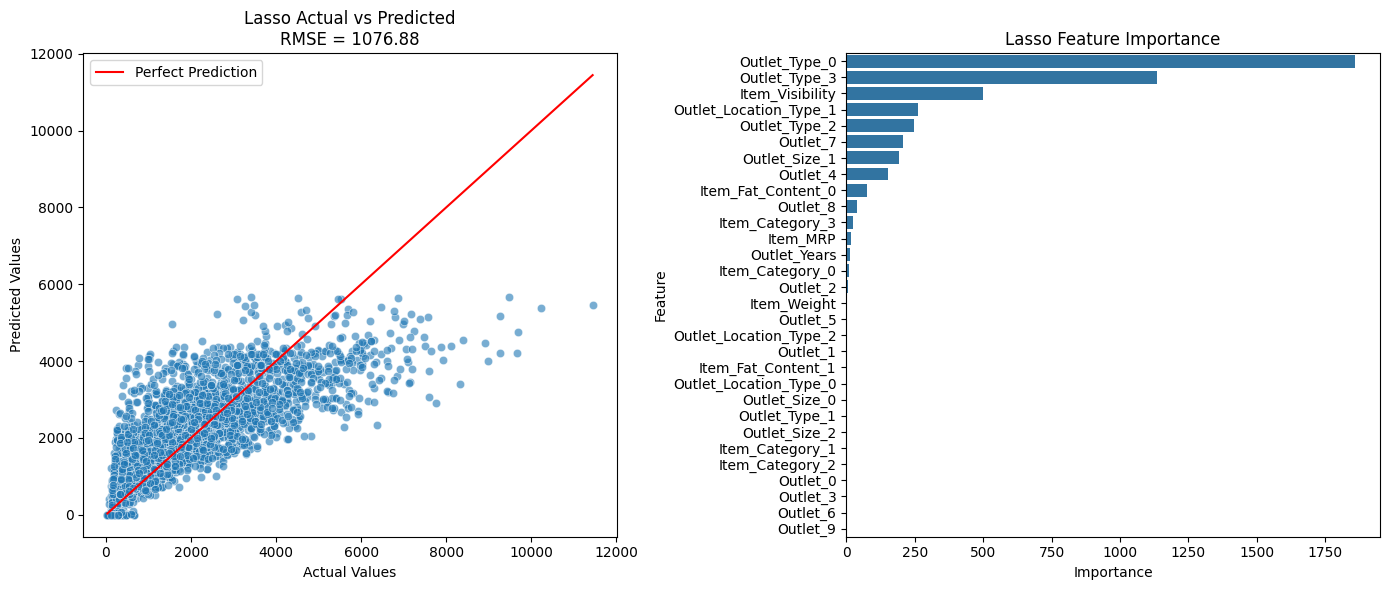

Training RandomForest...


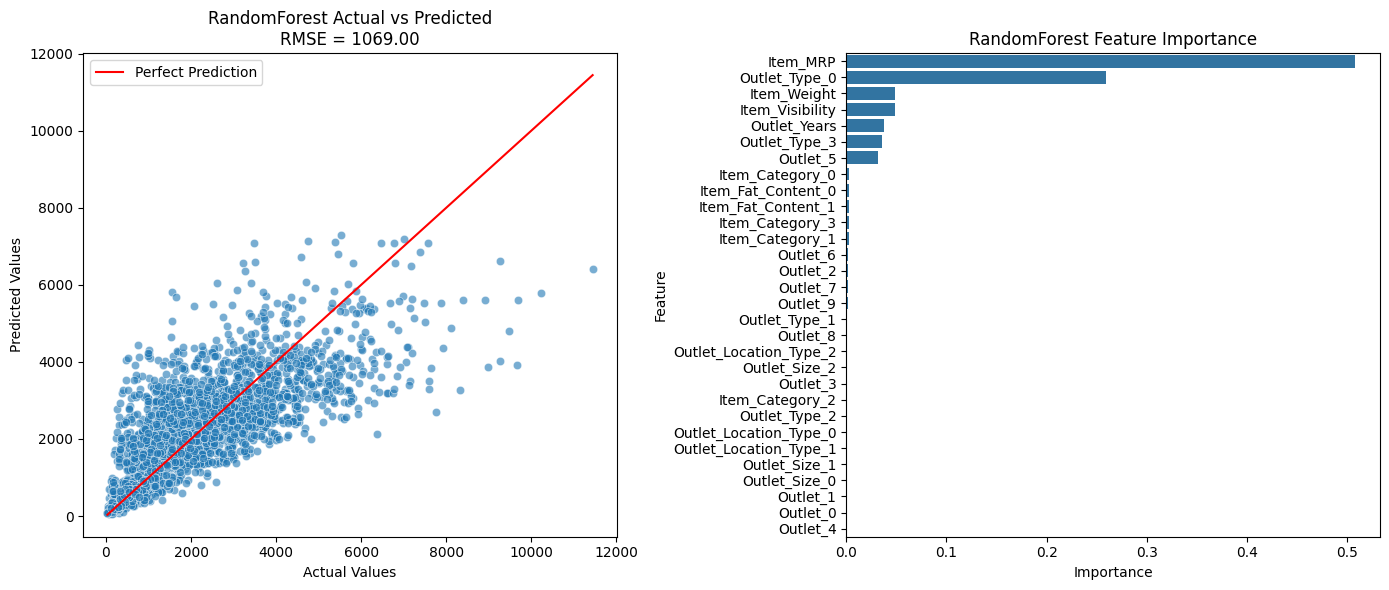

Training GradientBoosting...


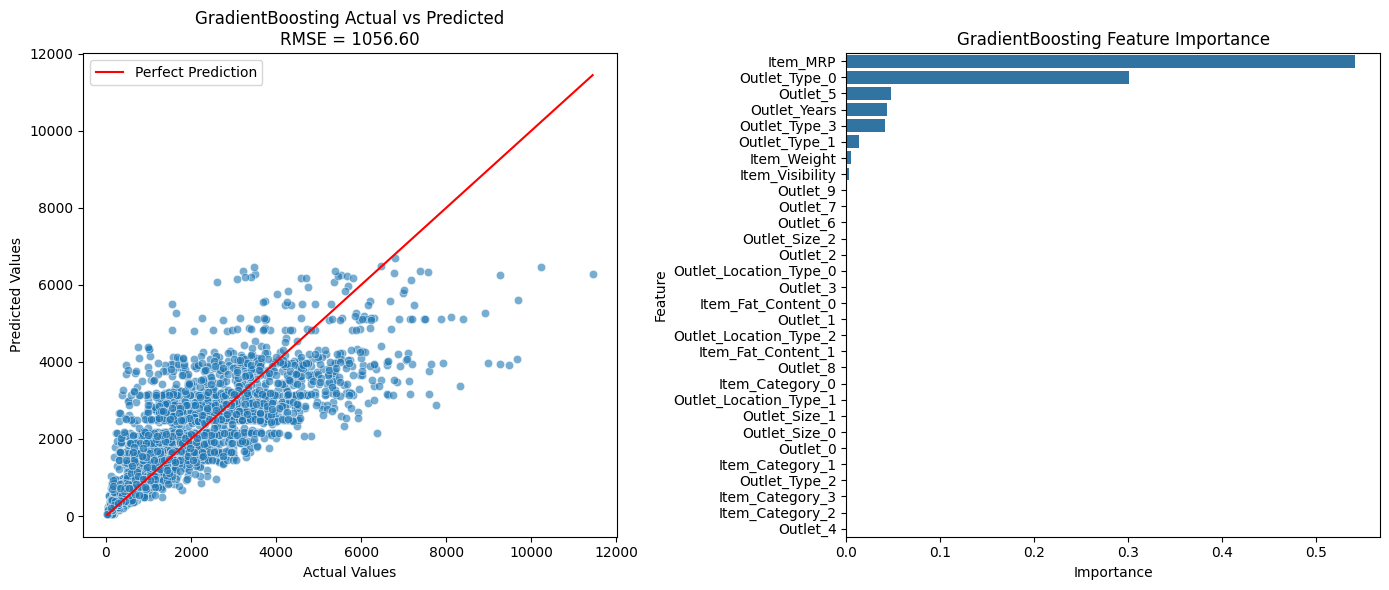

Training SVR...


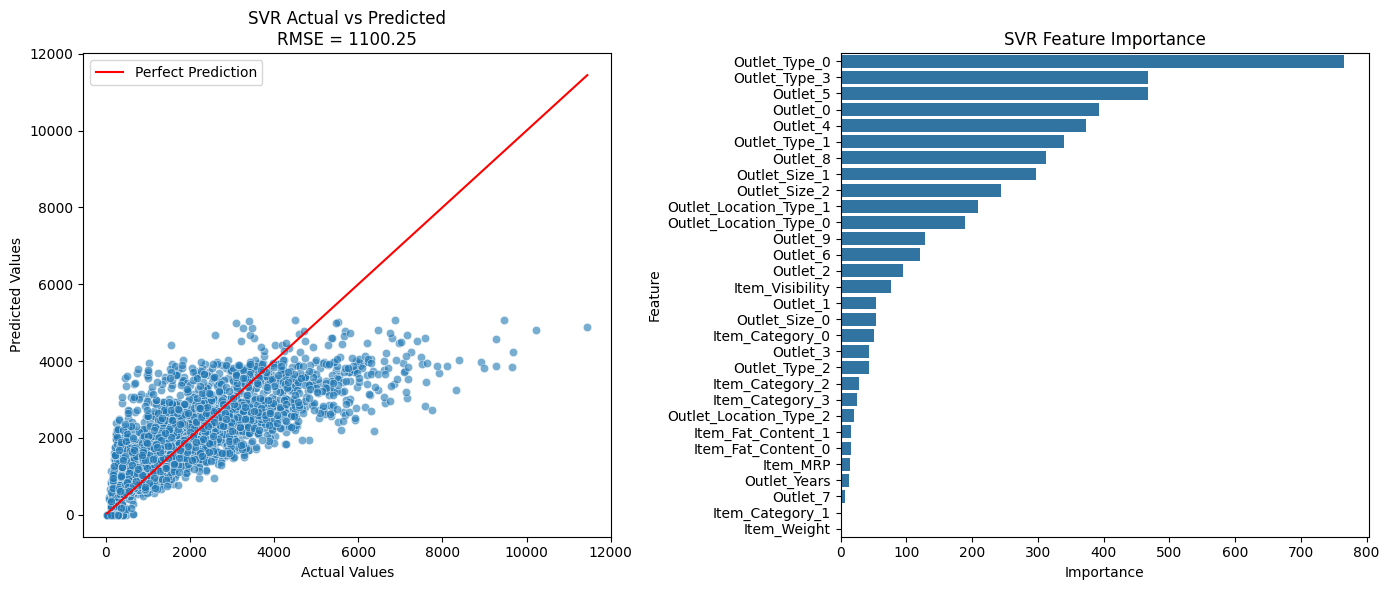

Training XGBRegressor...


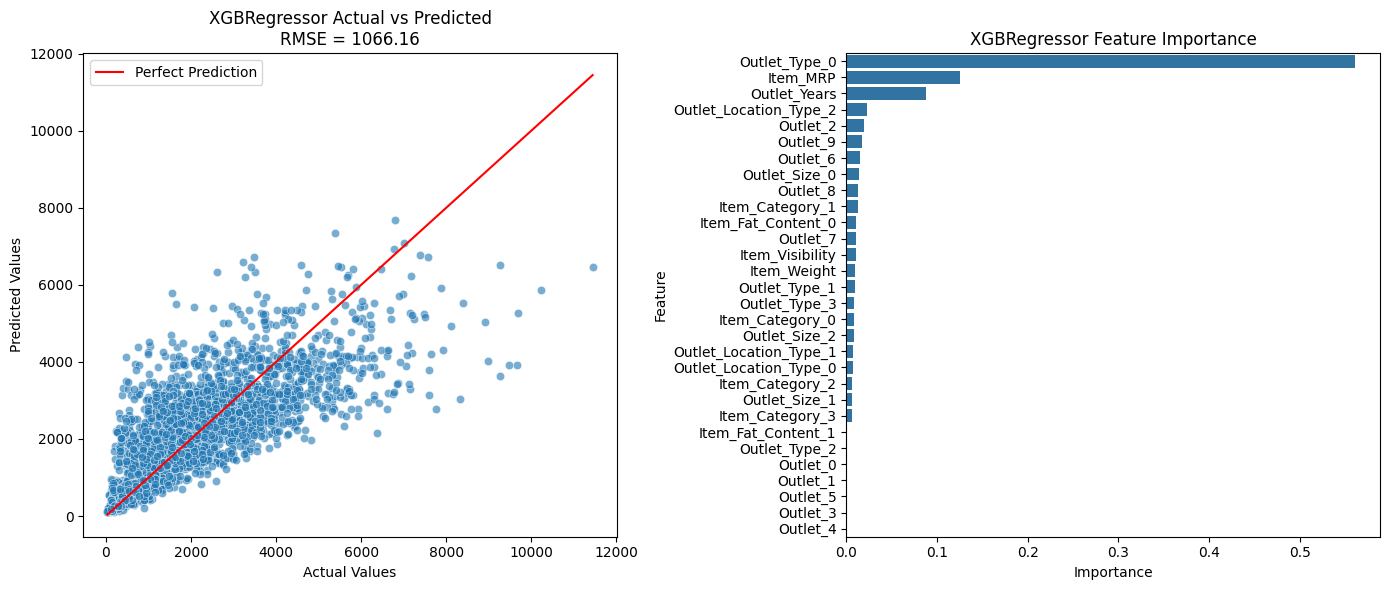

              Model  ...      MSLE
4  GradientBoosting  ...  0.306644
6      XGBRegressor  ...  0.300793
3      RandomForest  ...  0.296219
2             Lasso  ...  1.795960
0  LinearRegression  ...  1.801211
1             Ridge  ...  1.779644
5               SVR  ...  1.504186

[7 rows x 9 columns]


In [ ]:
X = train.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
y = train['Item_Outlet_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

models_params = {
    "LinearRegression": (LinearRegression(), {"fit_intercept": [True, False]}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1.0, 10]}),
    "Lasso": (Lasso(), {"alpha": [0.001, 0.01, 0.1]}),
    "RandomForest": (RandomForestRegressor(random_state=42), 
                     {"n_estimators": [100, 200], "max_depth": [None, 10]}),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), 
                         {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}),
    "SVR": (SVR(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "XGBRegressor": (XGBRegressor(random_state=42, eval_metric="rmse"), 
                     {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]})
}

def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def calculate_metrics(y_true, y_pred, p):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), p)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    try:
        msle = mean_squared_log_error(y_true, np.maximum(y_pred, 0))
    except:
        msle = np.nan
    return mae, mse, rmse, r2, adj_r2, mape, msle

results = []
train_results = X_train.copy()
train_results['Actual'] = y_train.values
val_results = X_val.copy()
val_results['Actual'] = y_val.values

for name, (model, params) in models_params.items():
    print(f"Training {name}...")
    
    grid = GridSearchCV(model, params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    # Predictions
    y_train_pred = np.clip(best_model.predict(X_train), 0, None)
    y_val_pred = np.clip(best_model.predict(X_val), 0, None)
    
    # Store predictions
    train_results[f"{name}_pred"] = y_train_pred
    val_results[f"{name}_pred"] = y_val_pred
    
    # Compute metrics
    mae, mse, rmse, r2, adj_r2, mape, msle = calculate_metrics(y_val, y_val_pred, X_val.shape[1])
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adj_r2,
        "MAPE": mape,
        "MSLE": msle
    })
    
    # Combined Actual vs Predicted + Feature Importance
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    # Actual vs Predicted
    sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, ax=axes[0])
    sns.lineplot(x=y_val, y=y_val, color='red', label='Perfect Prediction', ax=axes[0])
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")
    axes[0].set_title(f"{name} Actual vs Predicted\nRMSE = {rmse:.2f}")
    
    # Feature Importance
    feature_importances = None
    if hasattr(best_model, "feature_importances_"):
        feature_importances = best_model.feature_importances_
    elif hasattr(best_model, "coef_"):
        feature_importances = np.abs(best_model.coef_)
        if feature_importances.ndim > 1:
            feature_importances = feature_importances.flatten()
    
    if feature_importances is not None:
        fi_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)
        sns.barplot(x="Importance", y="Feature", data=fi_df, ax=axes[1])
        axes[1].set_title(f"{name} Feature Importance")
    else:
        axes[1].text(0.5, 0.5, "No Feature Importance", horizontalalignment='center', verticalalignment='center')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Results dataframe
results_df = pd.DataFrame(results).sort_values(by="RMSE")


In [92]:
results_df

Model  ...      MSLE
4  GradientBoosting  ...  0.306644
6      XGBRegressor  ...  0.300793
3      RandomForest  ...  0.296219
2             Lasso  ...  1.795960
0  LinearRegression  ...  1.801211
1             Ridge  ...  1.779644
5               SVR  ...  1.504186

[7 rows x 9 columns]

In [93]:
# 1️⃣ Add 'Set' column
train_results['Set'] = 'Train'
val_results['Set'] = 'Validation'

# 2️⃣ Concatenate train and validation results
all_results = pd.concat([train_results, val_results], ignore_index=True)

# 3️⃣ Reorder columns to have 'Set' and 'Actual' first
cols = ['Set', 'Actual'] + [c for c in all_results.columns if c not in ['Set', 'Actual']]
all_results = all_results[cols]

In [94]:
# 4️⃣ Identify prediction columns
pred_cols = [c for c in all_results.columns if c.endswith("_pred")]

# 5️⃣ Compute absolute error for each prediction
errors = all_results[pred_cols].sub(all_results['Actual'], axis=0).abs()

# 6️⃣ Find the column (model) with minimum error for each row
all_results['Best_Model_Rowwise'] = errors.idxmin(axis=1)
all_results['Best_Model_Rowwise'] = all_results['Best_Model_Rowwise'].str.replace('_pred', '')

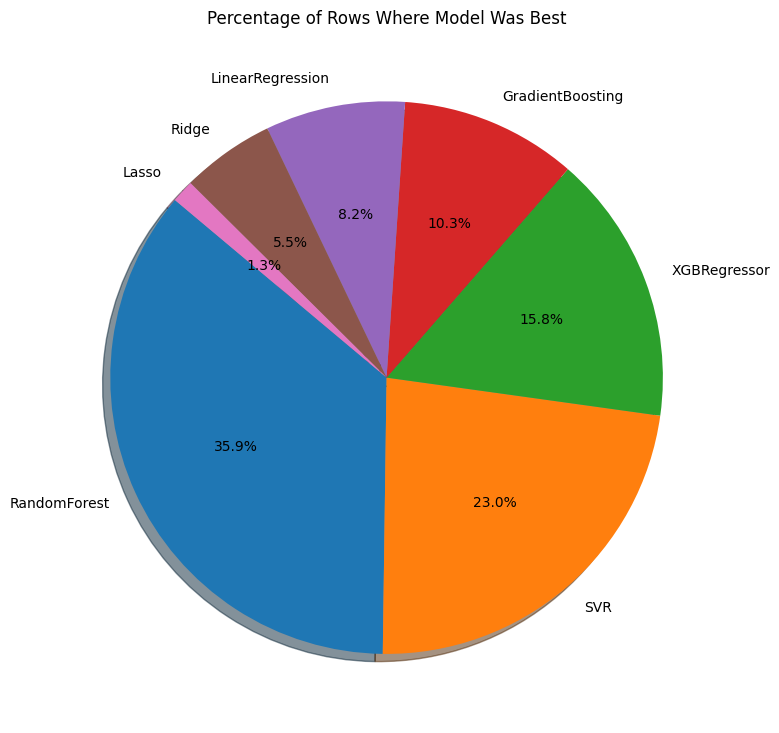

In [95]:

best_model_counts = all_results['Best_Model_Rowwise'].value_counts()
best_model_percent = best_model_counts / best_model_counts.sum() * 100

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(best_model_percent, labels=best_model_percent.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title("Percentage of Rows Where Model Was Best")
plt.tight_layout()
plt.show()

In [96]:

# 7️⃣ Create combined prediction from top 3 models (based on RMSE from results_df)
top_models = results_df.sort_values('RMSE').head(3)['Model'].tolist()
top_pred_cols = [f"{model}_pred" for model in top_models]

In [97]:
all_results['Top_Combined_pred'] = all_results[top_pred_cols].mean(axis=1)

In [98]:
rmse_top4 = np.sqrt(mean_squared_error(all_results['Actual'], all_results['Top_Combined_pred']))
print(f"RMSE for Top_Combined_pred: {rmse_top4:.2f}")

RMSE for Top_Combined_pred: 992.18


In [99]:
# 4️⃣ Identify prediction columns
pred_cols = [c for c in all_results.columns if c.endswith("_pred")]

# 5️⃣ Compute absolute error for each prediction
errors = all_results[pred_cols].sub(all_results['Actual'], axis=0).abs()

# 6️⃣ Find the column (model) with minimum error for each row
all_results['Best_Model_Rowwise'] = errors.idxmin(axis=1)
all_results['Best_Model_Rowwise'] = all_results['Best_Model_Rowwise'].str.replace('_pred', '')

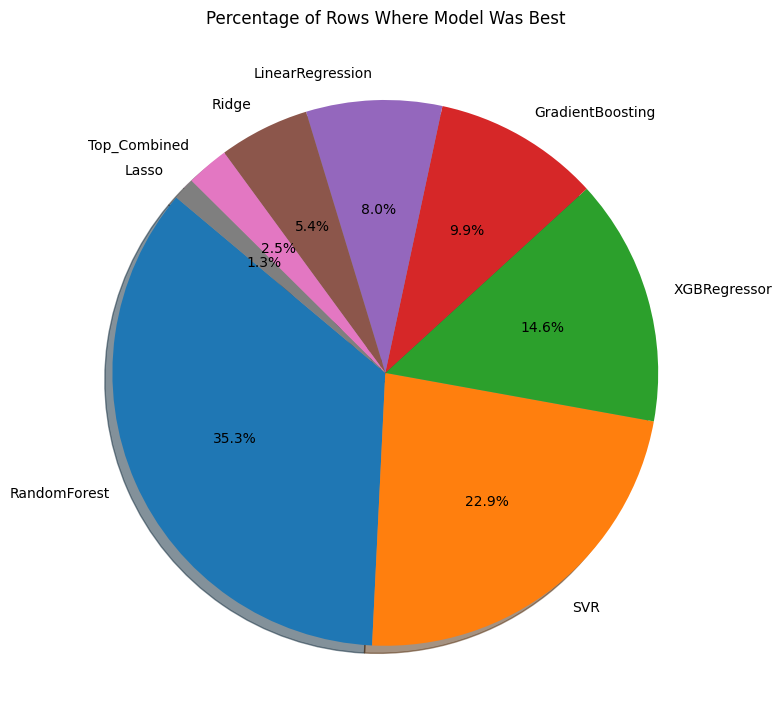

In [100]:

best_model_counts = all_results['Best_Model_Rowwise'].value_counts()
best_model_percent = best_model_counts / best_model_counts.sum() * 100

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(best_model_percent, labels=best_model_percent.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title("Percentage of Rows Where Model Was Best")
plt.tight_layout()
plt.show()

In [101]:
all_results[all_results['Set'] == "Validation"].sort_values(by='Actual')

Set      Actual  ...  Best_Model_Rowwise  Top_Combined_pred
6614  Validation     33.2900  ...    GradientBoosting          73.912315
8252  Validation     33.9558  ...    GradientBoosting          68.692014
8483  Validation     34.6216  ...    GradientBoosting          83.197223
8431  Validation     37.9506  ...    GradientBoosting          96.437530
7771  Validation     37.9506  ...    GradientBoosting          78.415590
...          ...         ...  ...                 ...                ...
6927  Validation   9467.6760  ...    LinearRegression        4214.809281
7122  Validation   9664.7528  ...    LinearRegression        3971.941485
7822  Validation   9678.0688  ...    GradientBoosting        5496.031651
6258  Validation  10236.6750  ...    GradientBoosting        6030.758805
8128  Validation  11445.1020  ...        XGBRegressor        6388.666250

[2557 rows x 41 columns]

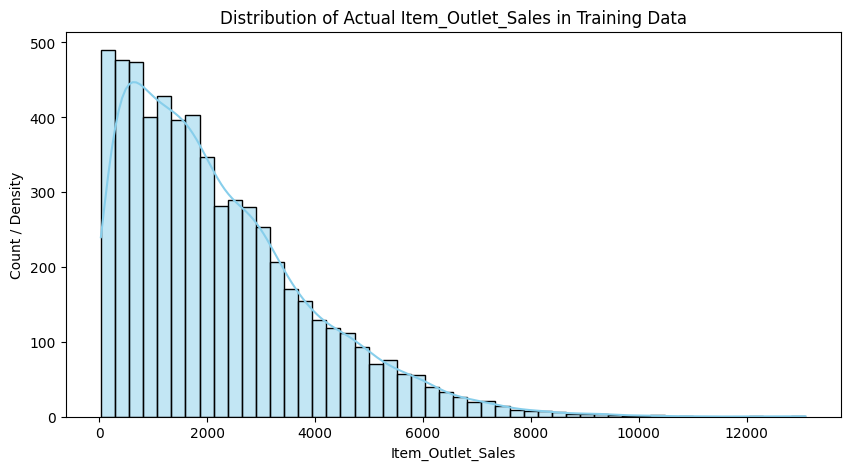

In [103]:
plt.figure(figsize=(10,5))
sns.histplot(y_train, bins=50, kde=True, color='skyblue')
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Count / Density")
plt.title("Distribution of Actual Item_Outlet_Sales in Training Data")
plt.show()

In [ ]:
percentile_90 = y_train.quantile(0.9)
print(f"90th percentile of Item_Outlet_Sales: {percentile_90:.2f}")

In [113]:
train['Item_Outlet_Sales'].quantile(0.99)

np.float64(7366.011720000013)

In [112]:
len(train[train['Item_Outlet_Sales'] > train['Item_Outlet_Sales'].quantile(0.99)])/len(train)*100

1.0090343775665847

In [ ]:
train[train['Item_Outlet_Sales'] < train['Item_Outlet_Sales'].quantile(0.99)]

Training LinearRegression...


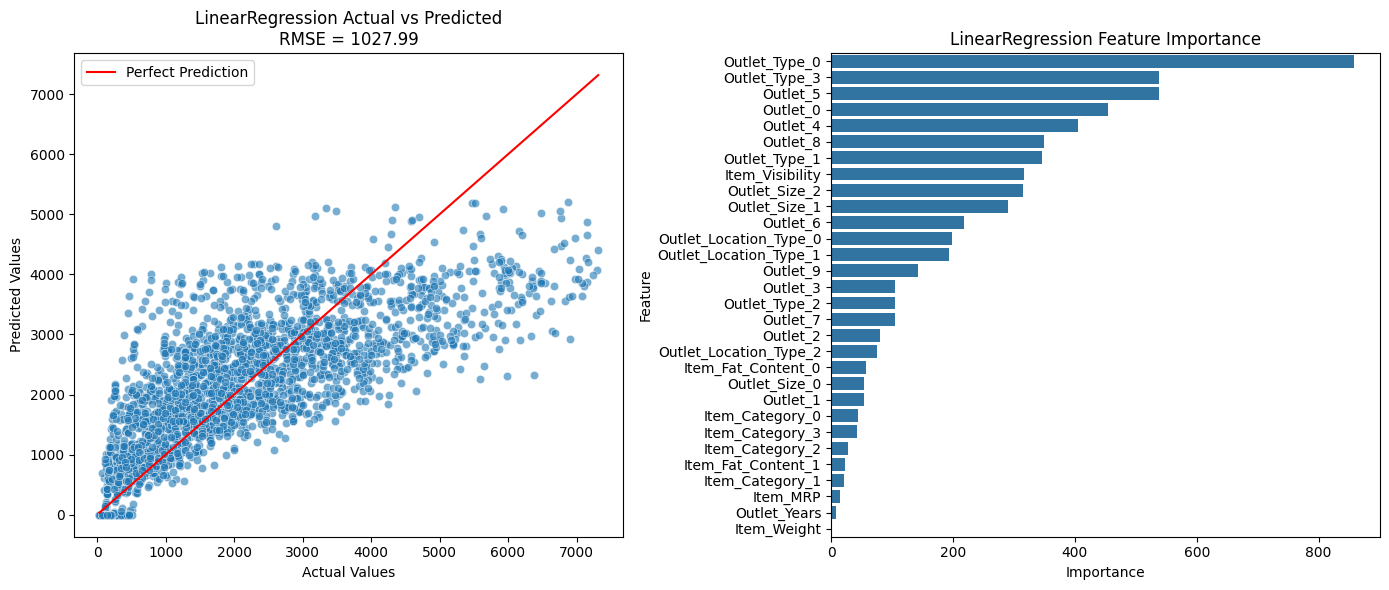

Training Ridge...


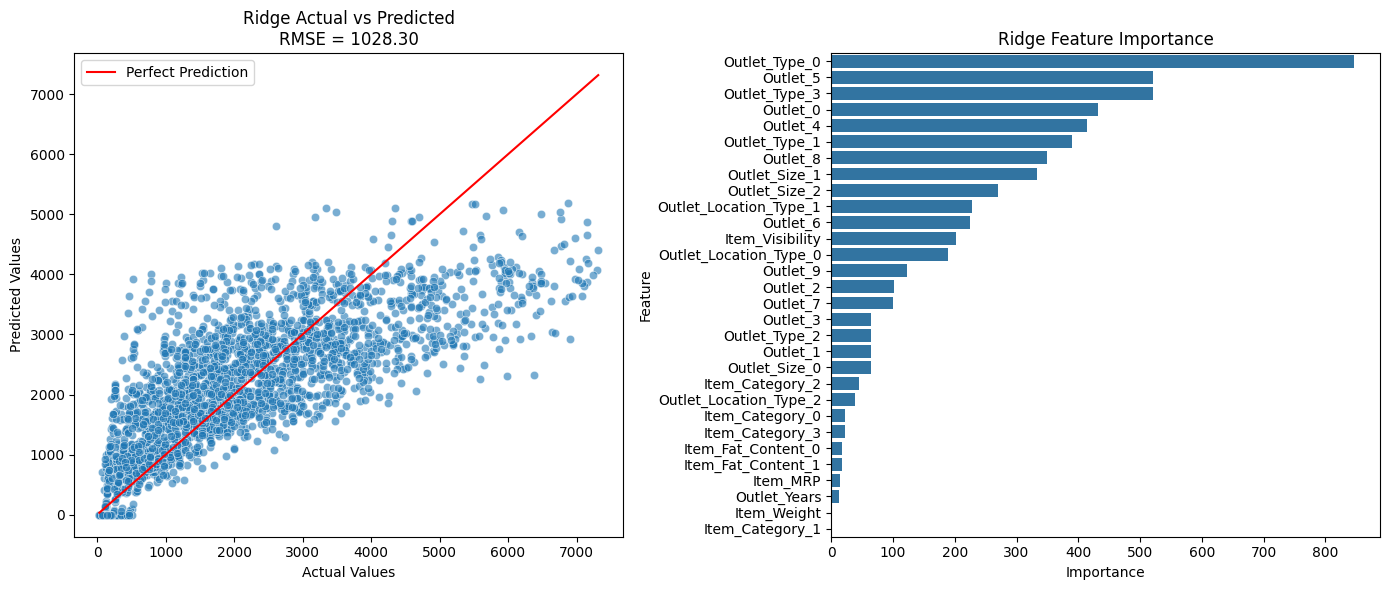

Training Lasso...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+09, tolerance: 1.489e+06
  model = cd_fast.enet_coordinate_descent(


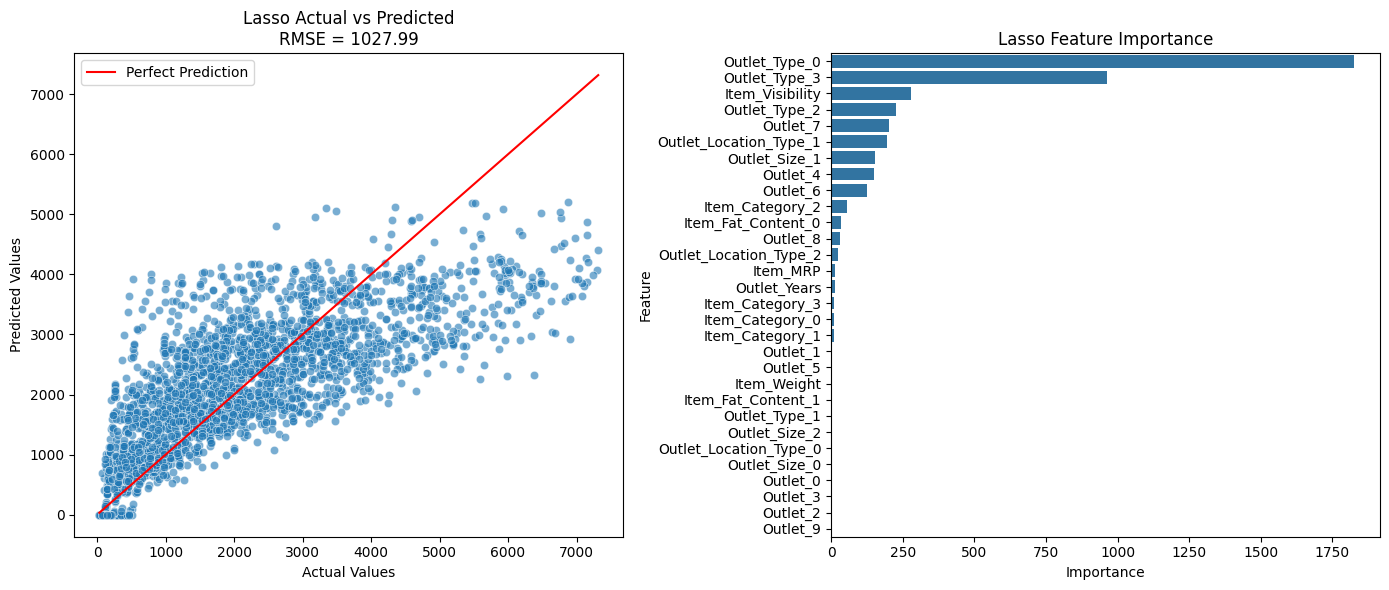

Training RandomForest...


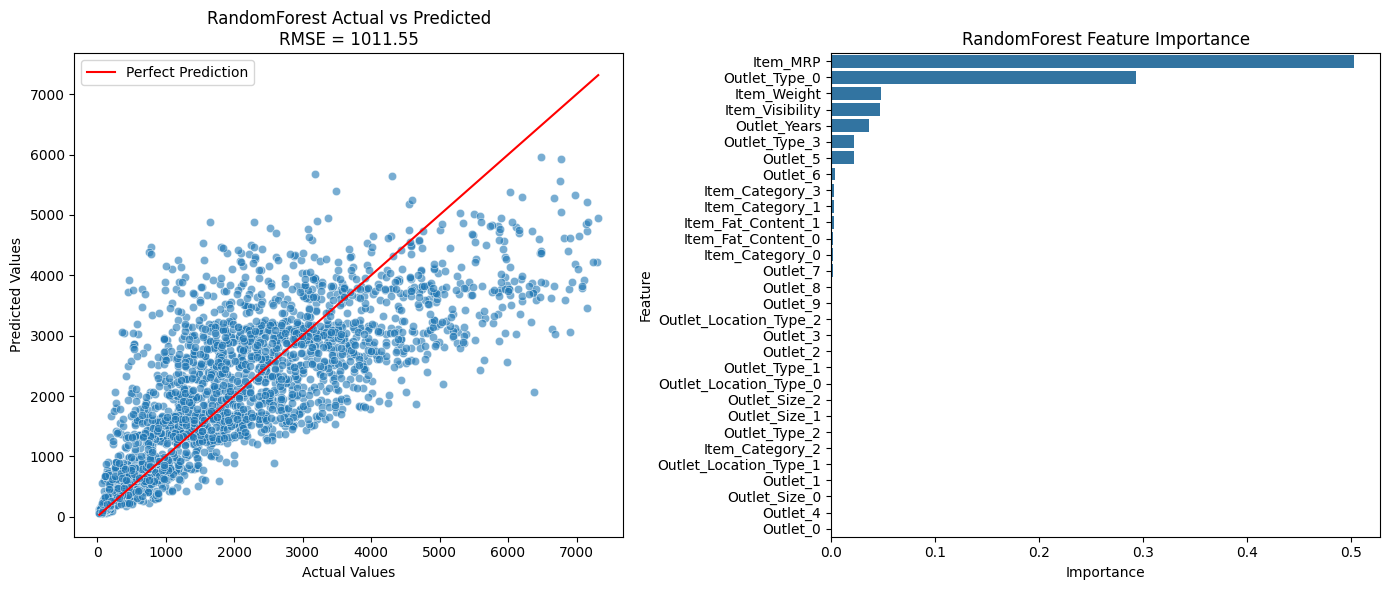

Training GradientBoosting...


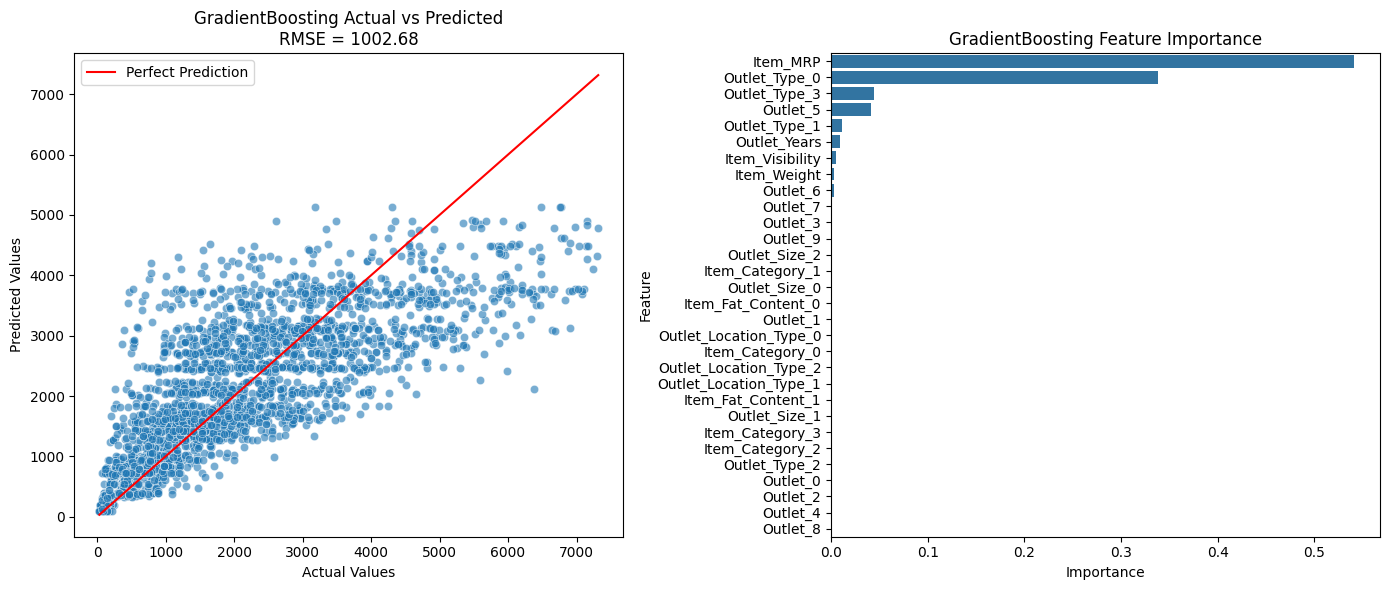

Training SVR...


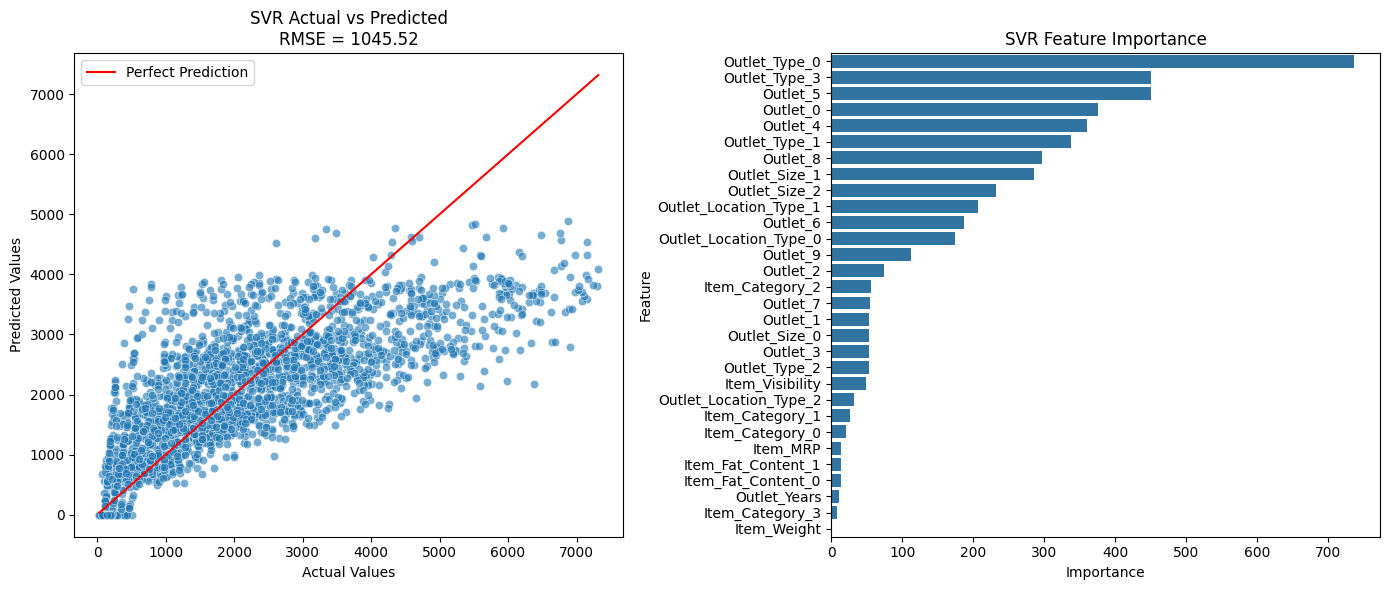

Training XGBRegressor...


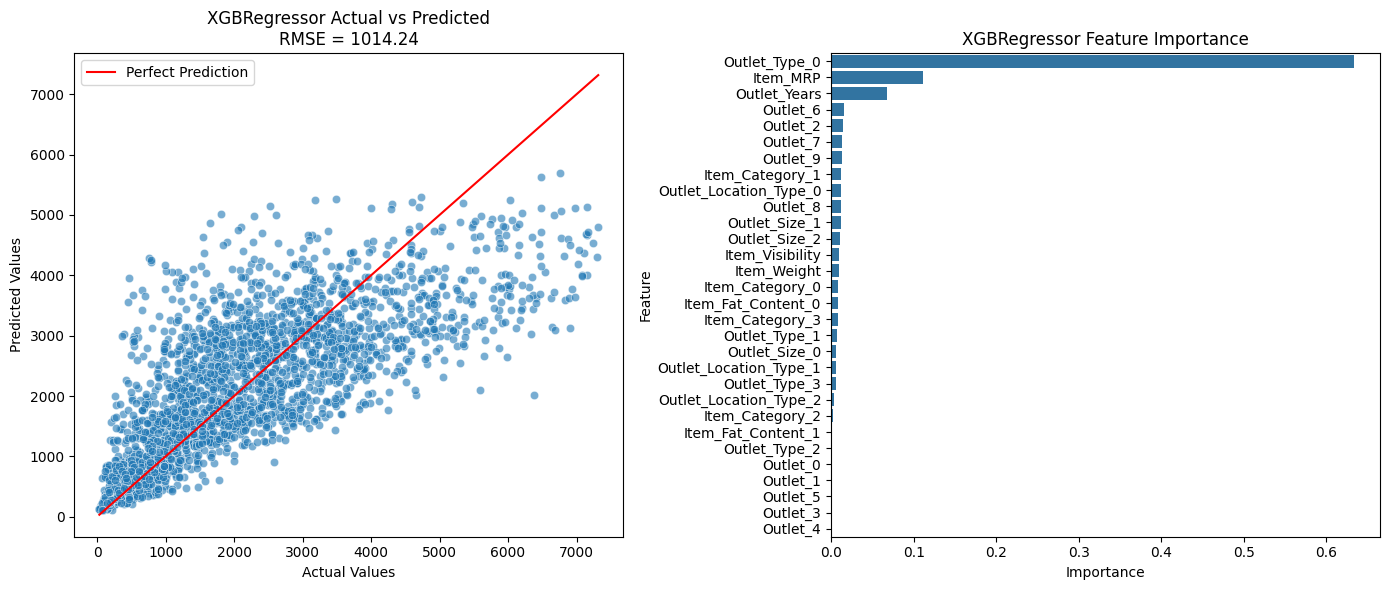

In [114]:
X = train[train['Item_Outlet_Sales'] < train['Item_Outlet_Sales'].quantile(0.99)].drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
y = train[train['Item_Outlet_Sales'] < train['Item_Outlet_Sales'].quantile(0.99)]['Item_Outlet_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

models_params = {
    "LinearRegression": (LinearRegression(), {"fit_intercept": [True, False]}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1.0, 10]}),
    "Lasso": (Lasso(), {"alpha": [0.001, 0.01, 0.1]}),
    "RandomForest": (RandomForestRegressor(random_state=42), 
                     {"n_estimators": [100, 200], "max_depth": [None, 10]}),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42), 
                         {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}),
    "SVR": (SVR(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "XGBRegressor": (XGBRegressor(random_state=42, eval_metric="rmse"), 
                     {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]})
}

def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def calculate_metrics(y_true, y_pred, p):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), p)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    try:
        msle = mean_squared_log_error(y_true, np.maximum(y_pred, 0))
    except:
        msle = np.nan
    return mae, mse, rmse, r2, adj_r2, mape, msle

results = []
train_results = X_train.copy()
train_results['Actual'] = y_train.values
val_results = X_val.copy()
val_results['Actual'] = y_val.values

for name, (model, params) in models_params.items():
    print(f"Training {name}...")
    
    grid = GridSearchCV(model, params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    # Predictions
    y_train_pred = np.clip(best_model.predict(X_train), 0, None)
    y_val_pred = np.clip(best_model.predict(X_val), 0, None)
    
    # Store predictions
    train_results[f"{name}_pred"] = y_train_pred
    val_results[f"{name}_pred"] = y_val_pred
    
    # Compute metrics
    mae, mse, rmse, r2, adj_r2, mape, msle = calculate_metrics(y_val, y_val_pred, X_val.shape[1])
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adj_r2,
        "MAPE": mape,
        "MSLE": msle
    })
    
    # Combined Actual vs Predicted + Feature Importance
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    # Actual vs Predicted
    sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, ax=axes[0])
    sns.lineplot(x=y_val, y=y_val, color='red', label='Perfect Prediction', ax=axes[0])
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")
    axes[0].set_title(f"{name} Actual vs Predicted\nRMSE = {rmse:.2f}")
    
    # Feature Importance
    feature_importances = None
    if hasattr(best_model, "feature_importances_"):
        feature_importances = best_model.feature_importances_
    elif hasattr(best_model, "coef_"):
        feature_importances = np.abs(best_model.coef_)
        if feature_importances.ndim > 1:
            feature_importances = feature_importances.flatten()
    
    if feature_importances is not None:
        fi_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)
        sns.barplot(x="Importance", y="Feature", data=fi_df, ax=axes[1])
        axes[1].set_title(f"{name} Feature Importance")
    else:
        axes[1].text(0.5, 0.5, "No Feature Importance", horizontalalignment='center', verticalalignment='center')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Results dataframe
results_df = pd.DataFrame(results).sort_values(by="RMSE")


In [ ]:

train_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "test.csv"))

In [124]:
train_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [143]:
train_test = data[(data["source"] == "train_data") & (data["Item_Outlet_Sales"] >7500)]

In [145]:
train_df[train_df['Item_Type'] == "Snack Foods"][['Item_Type', 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']].sort_values(by='Item_Outlet_Sales')

Item_Type  Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales
2571  Snack Foods          NaN         0.134328   35.0558            33.9558
6871  Snack Foods          NaN         0.116794   41.0112            42.6112
4219  Snack Foods         7.63         0.225477   45.1402            45.9402
5946  Snack Foods          NaN         0.235859   46.1402            45.9402
6644  Snack Foods          NaN         0.053939   52.1008            50.6008
...           ...          ...              ...       ...                ...
2293  Snack Foods        10.80         0.029002  238.6222          8604.7992
3154  Snack Foods          NaN         0.049066  192.4478          8912.3988
6409  Snack Foods        13.65         0.035931  184.4924          9069.5276
333   Snack Foods          NaN         0.056597  230.9984          9267.9360
4349  Snack Foods          NaN         0.088840  254.2672         10993.6896

[1200 rows x 5 columns]

In [122]:
test[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Years']].sort_values(by='Item_MRP')

Item_Weight  Item_Visibility  Item_MRP  Outlet_Years
2276        9.105         0.038450   31.9900            26
3870       19.250         0.108250   32.0558            11
30          9.105         0.067377   32.0900            28
1229        9.105         0.038296   32.3900            28
3845        9.500         0.041886   32.3900            16
...           ...              ...       ...           ...
4910        6.465         0.124700  266.0884            14
4990       10.300         0.117233  266.2226            15
2883        6.825         0.060091  266.3226             4
3796       17.000         0.139739  266.4884            14
3380       17.000         0.139496  266.5884             9

[5681 rows x 4 columns]